# Notebook 04 - Feature Engineering

## Objectives

Engineer Features for:
* Classification
* Regression
* Clustering

## Inputs
* outputs/datasets/cleaned/test.csv

## Outputs
* Create Clean dataset:
    * all new datasets of cleaning will be stored in inputs/datasets/cleaning
* Split created dataset in to 3 parts:
    * Train
    * Validate
    * Test
* all new datasets (train, validate and test) will be stored in outputs/datasets/cleaned

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df = pd.read_csv('outputs/datasets/cleaned/test.csv')
df.head()

Unnamed: 0  1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  \
0         662      1392         0             2             3           0   
1        1187      1624         0             2             3        1456   
2        1305      1652         0             2             3        1572   
3         945      1188       561             3             3        1088   
4         269      1113         0             3             3         751   

   BsmtFinType1  BsmtUnfSF  EnclosedPorch  GarageArea  ...  LotFrontage  \
0             6       1392            120         576  ...          120   
1             2        168             89         757  ...           89   
2             2         80            108         840  ...          108   
3             3          0             98         456  ...           98   
4             1        392             70         504  ...           70   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0         216            0            3            6         1392           0   
1           0          114            5            8         1624           0   
2         300          102            5            9         1652           0   
3           0            0            6            5         1088           0   
4         174           30            7            6         1143           0   

   YearBuilt  YearRemodAdd  SalePrice  
0       1968          1968     110000  
1       1994          1995     262000  
2       2006          2007     325000  
3       1890          1996     124900  
4       1976          1976     148000  

[5 rows x 25 columns]

## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we will select these features:

['TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'GarageArea', 'GarageYrBlt', 'OverallQual', 'GrLivArea', 'SalePrice']
We will explore potential transformation for variables in our features 

In [5]:
selected_features = ['TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'GarageArea', 'GarageYrBlt', 'OverallQual', 'GrLivArea', 'SalePrice']
df = df[selected_features]
df.head()

TotalBsmtSF  1stFlrSF  YearBuilt  GarageArea  GarageYrBlt  OverallQual  \
0         1392      1392       1968         576         1968            6   
1         1624      1624       1994         757         1994            8   
2         1652      1652       2006         840         2006            9   
3         1088      1188       1890         456         1963            5   
4         1143      1113       1976         504         1987            6   

   GrLivArea  SalePrice  
0       1392     110000  
1       1624     262000  
2       1652     325000  
3       1869     124900  
4       1113     148000

In [6]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Features Engineering

### Functions for transforming

We have added extra feature - results
It will be printed out on each analysis, also at the end of FeatureEngineeringAnalysis it will be returned to us, so we can analyze it bit easier.

In [7]:
%matplotlib inline
import seaborn as sns
import warnings
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, kurtosis, shapiro

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    list_column_transformers = []
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson", "min_max", "max_abs", "robust",
            "quantile_normal", "quantile_uniform", "sine", "cosine", ]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    list_applied_transformers=[]
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")

    for col in [column] + list_applied_transformers:
    
        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)


        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
        '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def DiagnosticPlots_Numerical(df, variable):
    """
    Generate diagnostic plots for a numerical variable including histogram, QQ plot, and boxplot.
    Additionally, calculate and display skewness, kurtosis, and Shapiro-Wilk test p-value.

    Parameters:
        df (DataFrame): The DataFrame containing the variable.
        variable (str): The name of the variable to analyze.
    """
    # Calculate statistics
    skewness = skew(df[variable].dropna())  # Skewness
    kurtosis_value = kurtosis(df[variable].dropna())  # Kurtosis
    _, p_value = shapiro(df[variable].dropna())  # Shapiro-Wilk test

    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    # Set titles including statistics
    axes[0].set_title(f'Histogram\nSkewness: {skewness:.3f}')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')

    # Display Shapiro-Wilk test result on figure
    fig.suptitle(f"{variable} (Skewness: {skewness:.3f}, Kurtosis: {kurtosis_value:.3f}, Shapiro-Wilk p-value: {p_value:.3g})", fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()




def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
            f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, FunctionTransformer
from feature_engine.transformation import LogTransformer, ReciprocalTransformer, BoxCoxTransformer, \
    YeoJohnsonTransformer


def FeatEngineering_Numerical(df_feat_eng, column):
    """
    Applies various feature engineering transformations to a specified column in the dataframe.

    Parameters:
        df_feat_eng (DataFrame): The dataframe containing the features for transformation.
        column (str): The specific column on which to apply the transformations.

    Returns:
        tuple: The transformed dataframe and a list of successfully applied transformation methods.
    """
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = LogTransformer(variables=[column])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = LogTransformer(variables=[column], base=10)
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = ReciprocalTransformer(variables=[column])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer (Yeo-Johnson)
    try:
        pt = PowerTransformer(method='yeo-johnson')
        df_feat_eng[f"{column}_power"] = pt.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = BoxCoxTransformer(variables=[column])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = YeoJohnsonTransformer(variables=[column])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    # MinMaxScaler
    try:
        mms = MinMaxScaler()
        df_feat_eng[f"{column}_min_max"] = mms.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_min_max")
    except Exception:
        df_feat_eng.drop([f"{column}_min_max"], axis=1, inplace=True)

    # MaxAbsScaler
    try:
        mas = MaxAbsScaler()
        df_feat_eng[f"{column}_max_abs"] = mas.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_max_abs")
    except Exception:
        df_feat_eng.drop([f"{column}_max_abs"], axis=1, inplace=True)

    # RobustScaler
    try:
        rs = RobustScaler()
        df_feat_eng[f"{column}_robust"] = rs.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_robust")
    except Exception:
        df_feat_eng.drop([f"{column}_robust"], axis=1, inplace=True)

    # QuantileTransformer with normal distribution output
    try:
        qtn = QuantileTransformer(output_distribution='normal')
        df_feat_eng[f"{column}_quantile_normal"] = qtn.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_quantile_normal")
    except Exception:
        df_feat_eng.drop([f"{column}_quantile_normal"], axis=1, inplace=True)

    # QuantileTransformer with uniform distribution output
    try:
        qtu = QuantileTransformer(output_distribution='uniform')
        df_feat_eng[f"{column}_quantile_uniform"] = qtu.fit_transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_quantile_uniform")
    except Exception:
        df_feat_eng.drop([f"{column}_quantile_uniform"], axis=1, inplace=True)

    # Sine transformation using FunctionTransformer
    try:
        st = FunctionTransformer(np.sin)
        df_feat_eng[f"{column}_sine"] = st.transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_sine")
    except Exception:
        df_feat_eng.drop([f"{column}_sine"], axis=1, inplace=True)

    # Cosine transformation using FunctionTransformer
    try:
        ct = FunctionTransformer(np.cos)
        df_feat_eng[f"{column}_cosine"] = ct.transform(df_feat_eng[[column]])
        list_methods_worked.append(f"{column}_cosine")
    except Exception:
        df_feat_eng.drop([f"{column}_cosine"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked



## Inspecting dataframe for columns that might not need to be transformed


* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson', 'TotalBsmtSF_min_max', 'TotalBsmtSF_max_abs', 'TotalBsmtSF_robust', 'TotalBsmtSF_quantile_normal', 'TotalBsmtSF_quantile_uniform', 'TotalBsmtSF_sine', 'TotalBsmtSF_cosine'] 



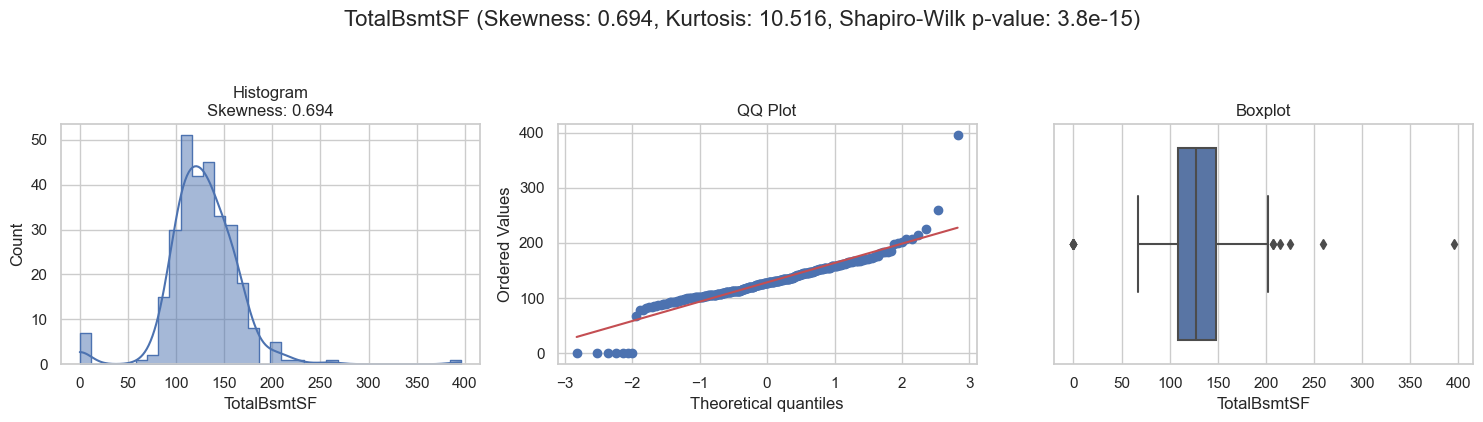

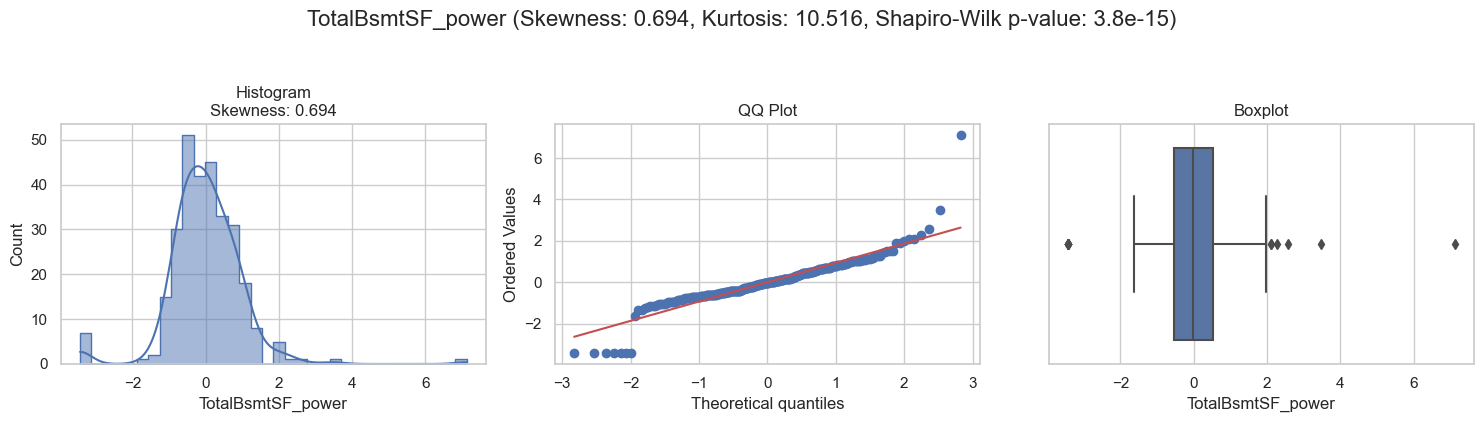

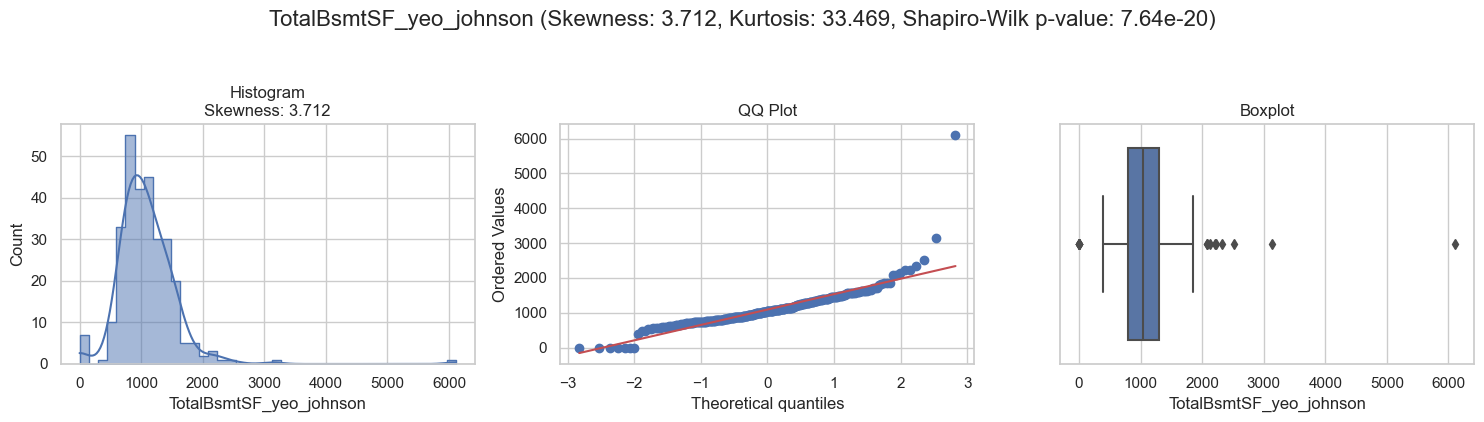

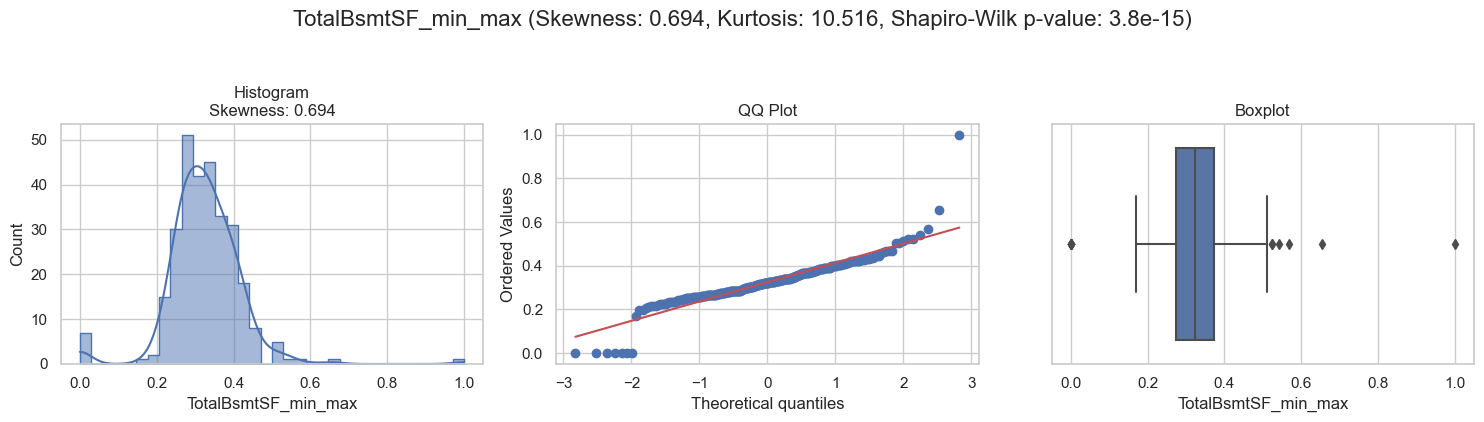

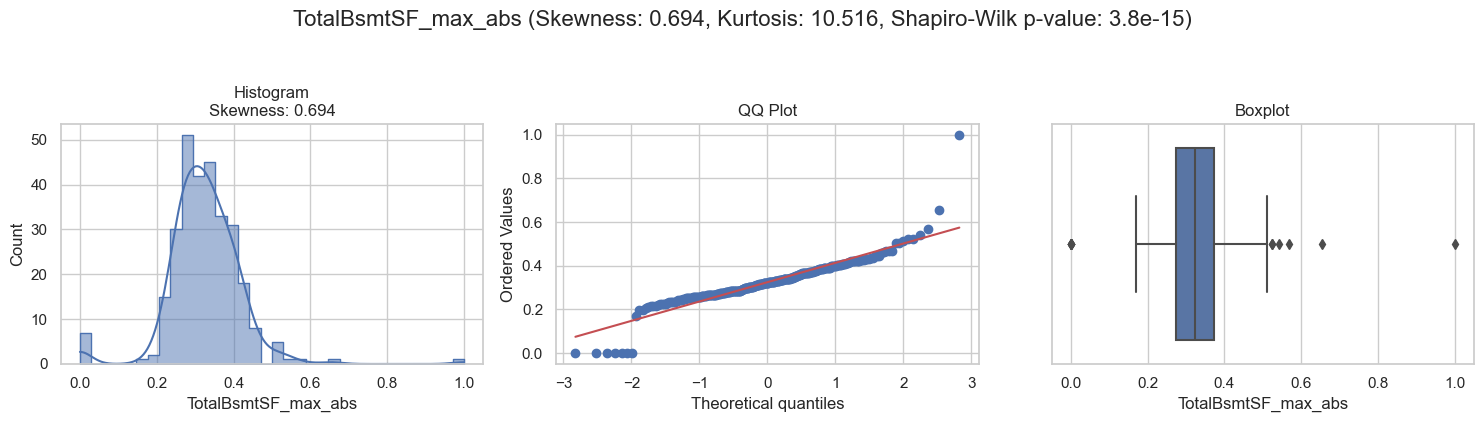

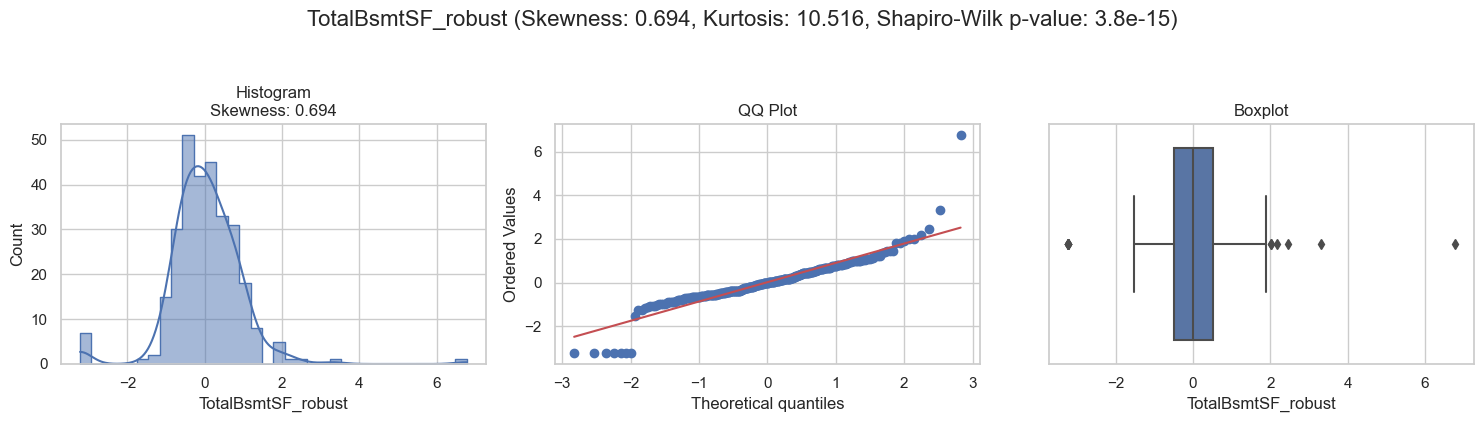

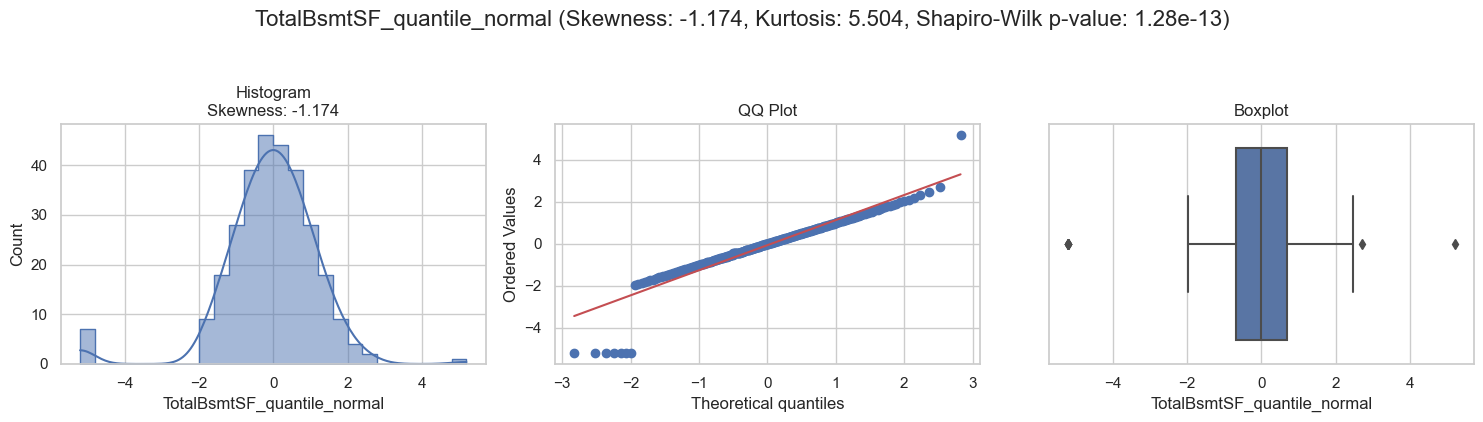

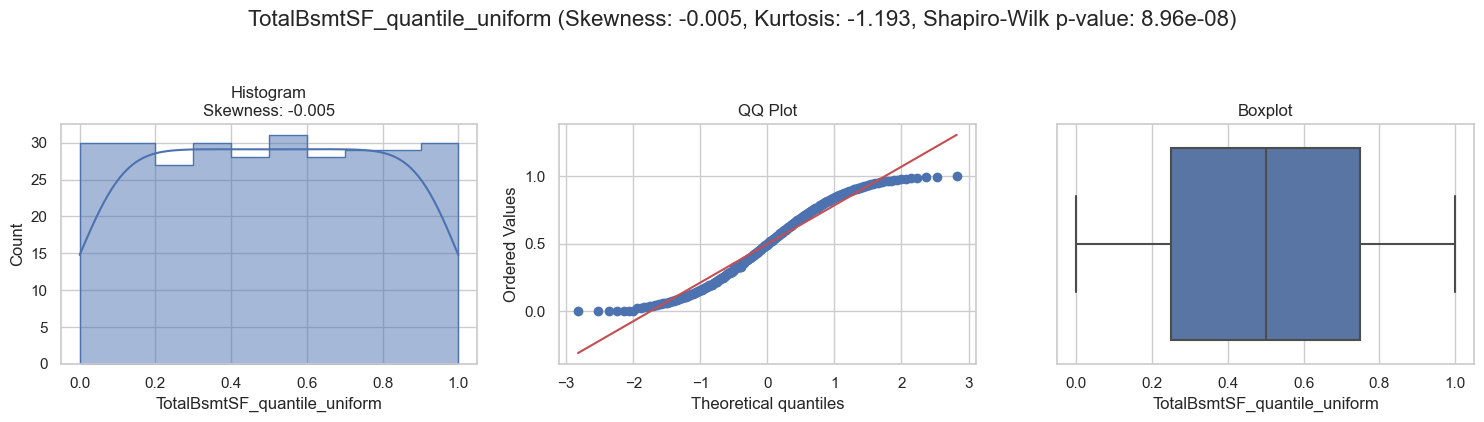

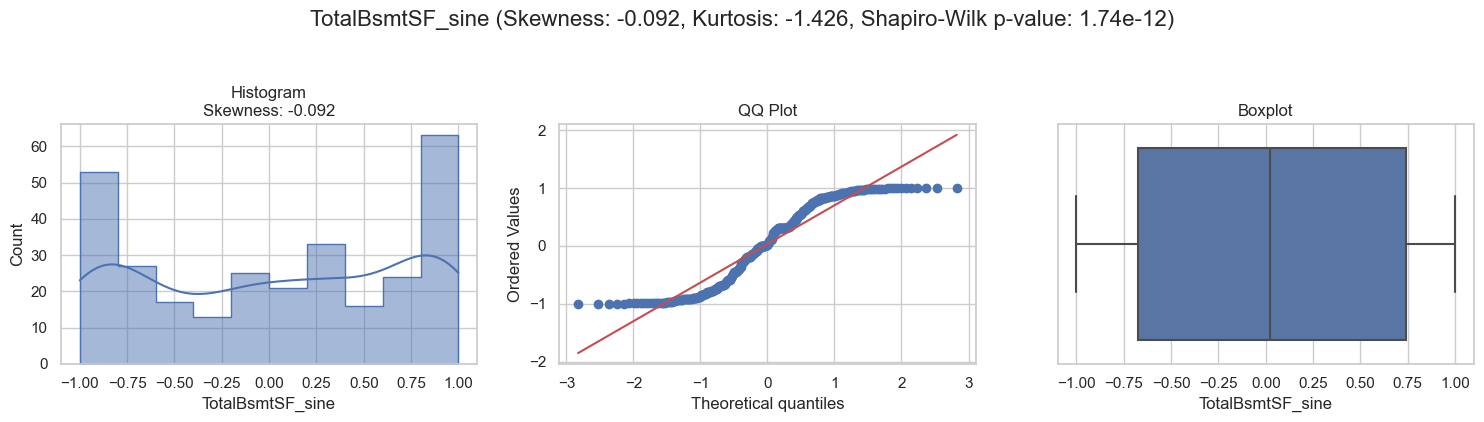

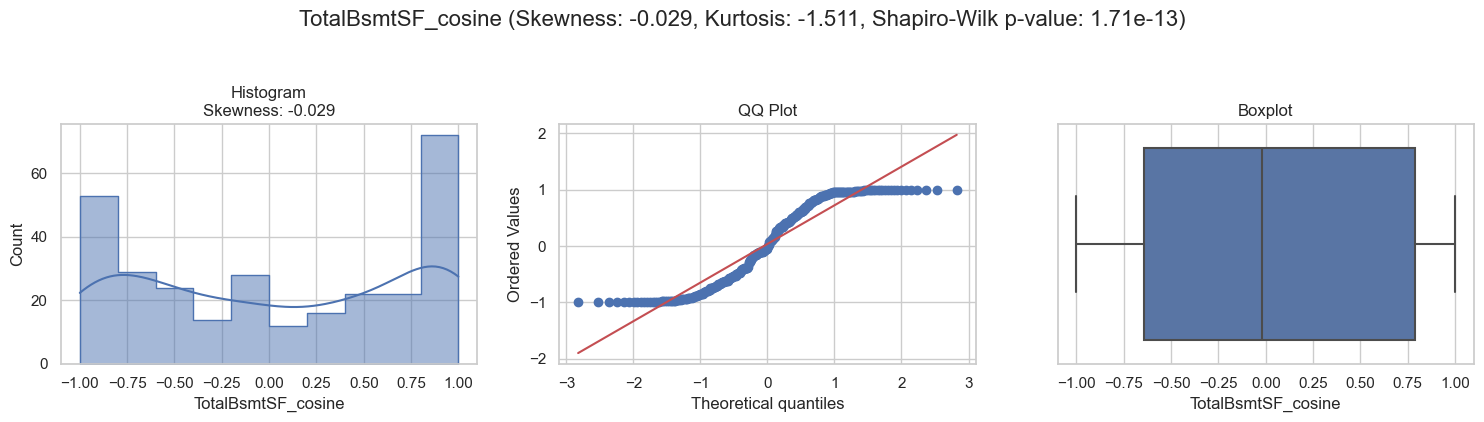



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson', '1stFlrSF_min_max', '1stFlrSF_max_abs', '1stFlrSF_robust', '1stFlrSF_quantile_normal', '1stFlrSF_quantile_uniform', '1stFlrSF_sine', '1stFlrSF_cosine'] 



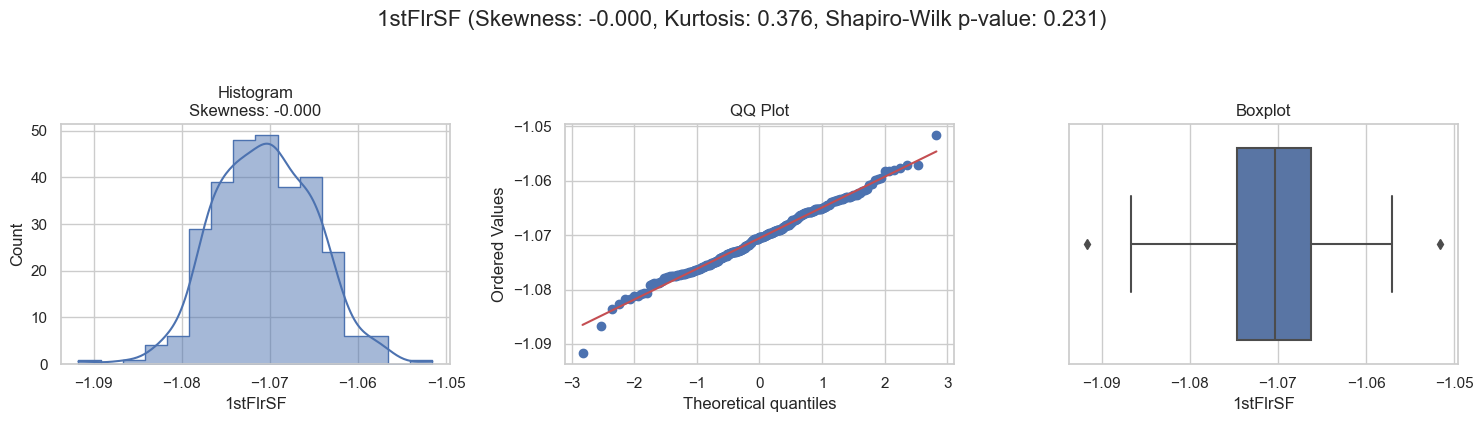

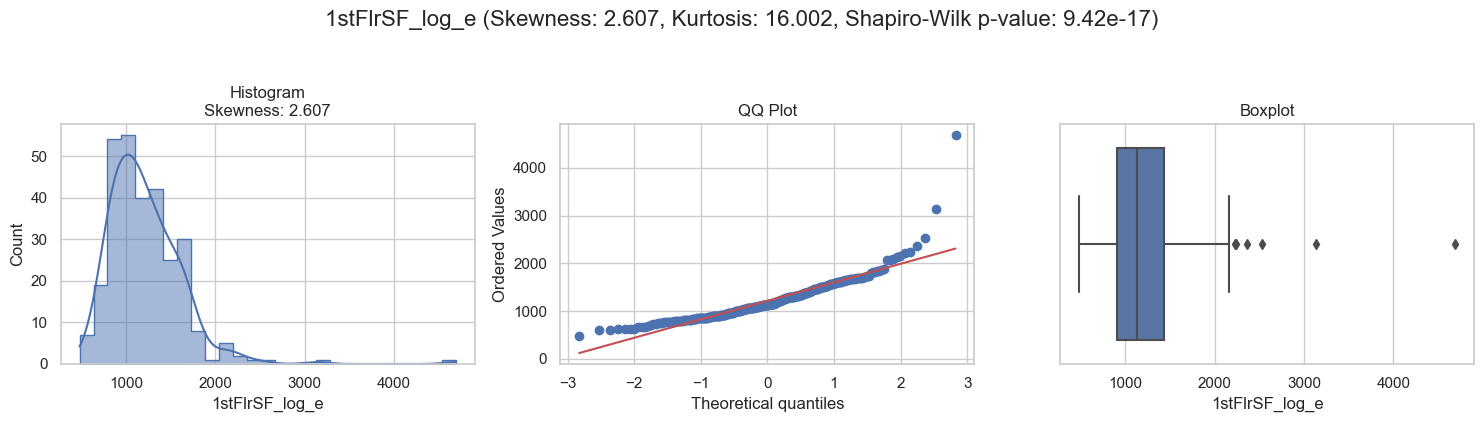

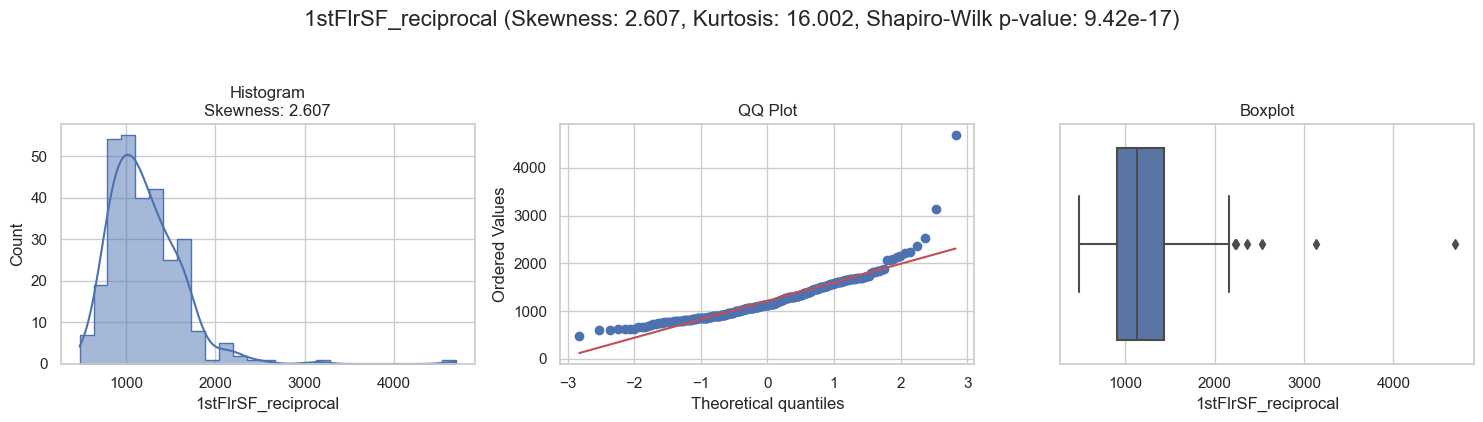

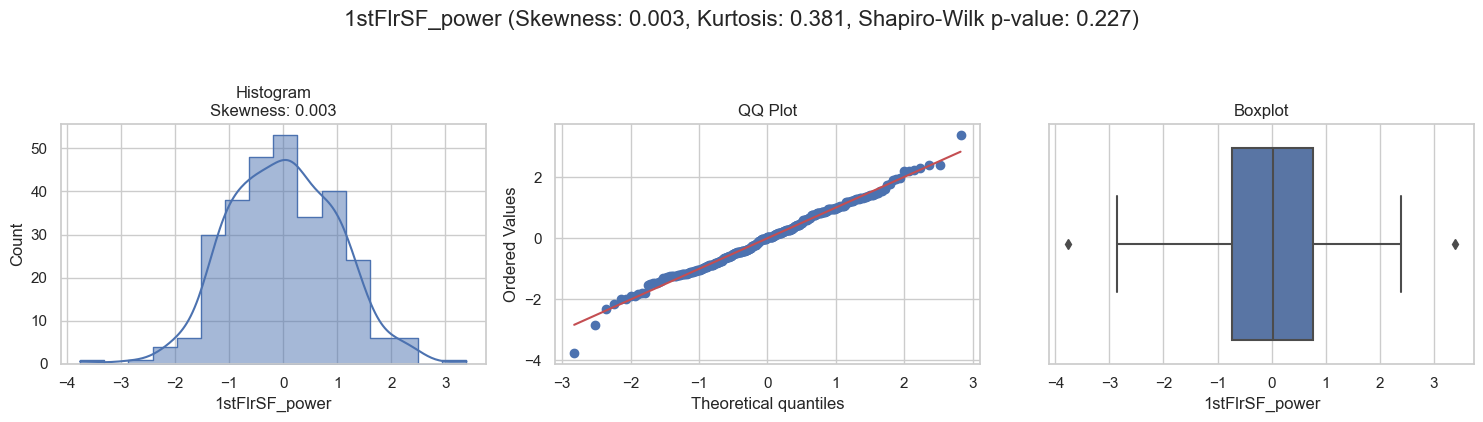

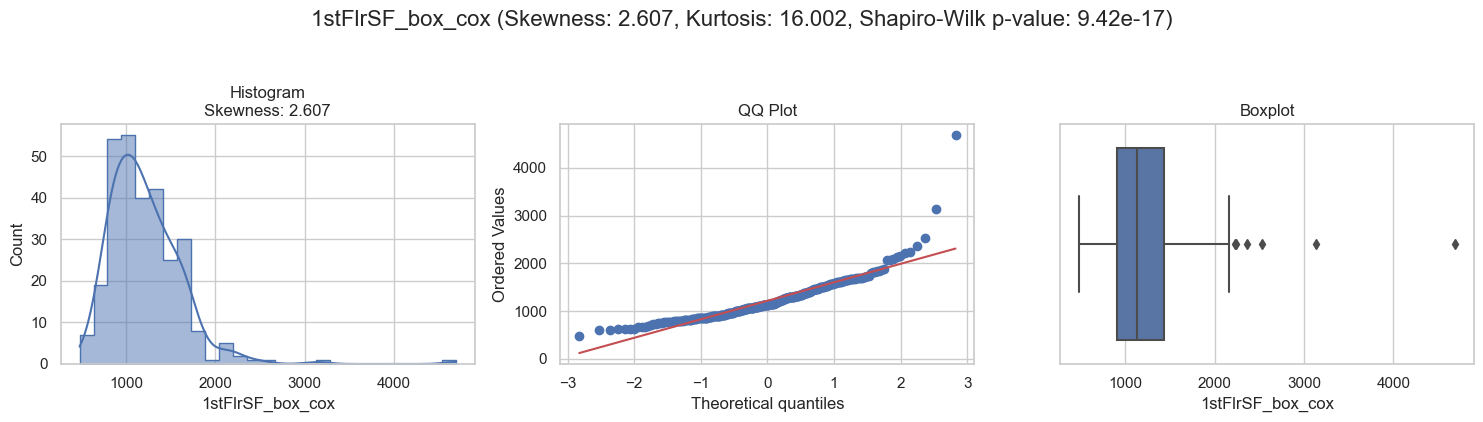

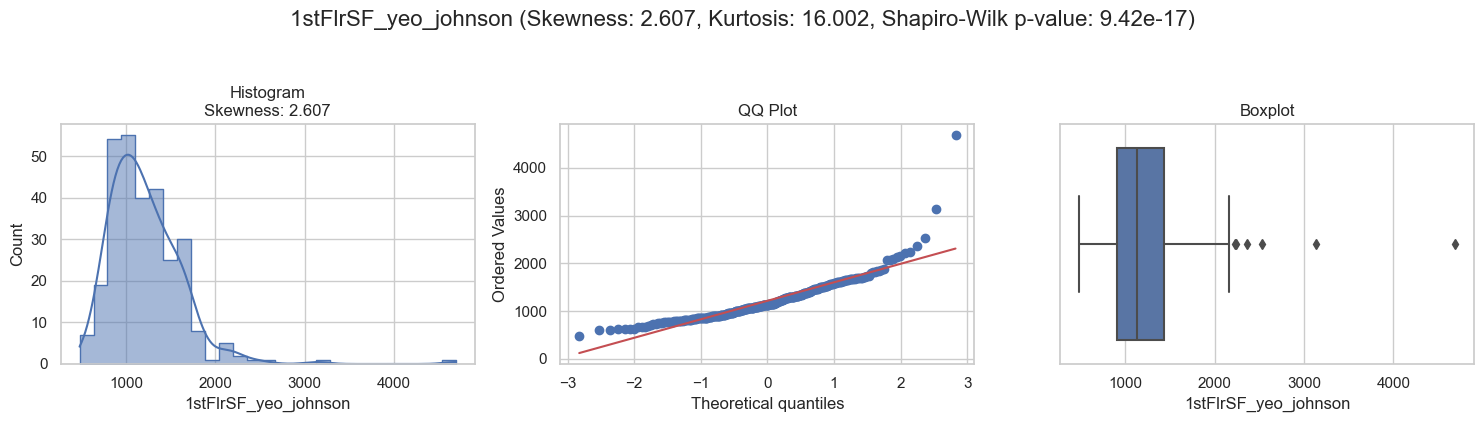

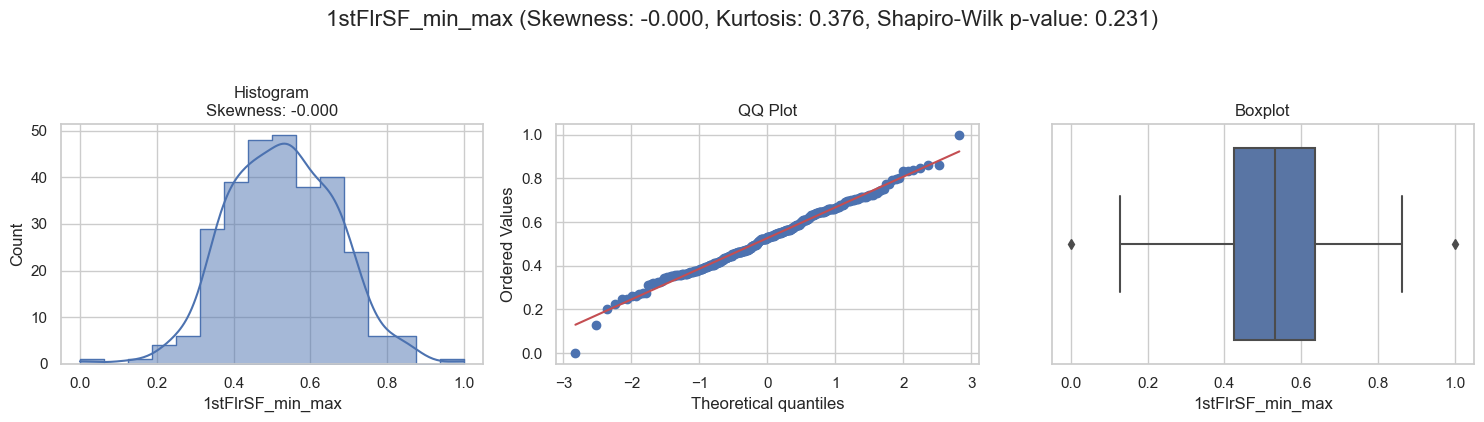

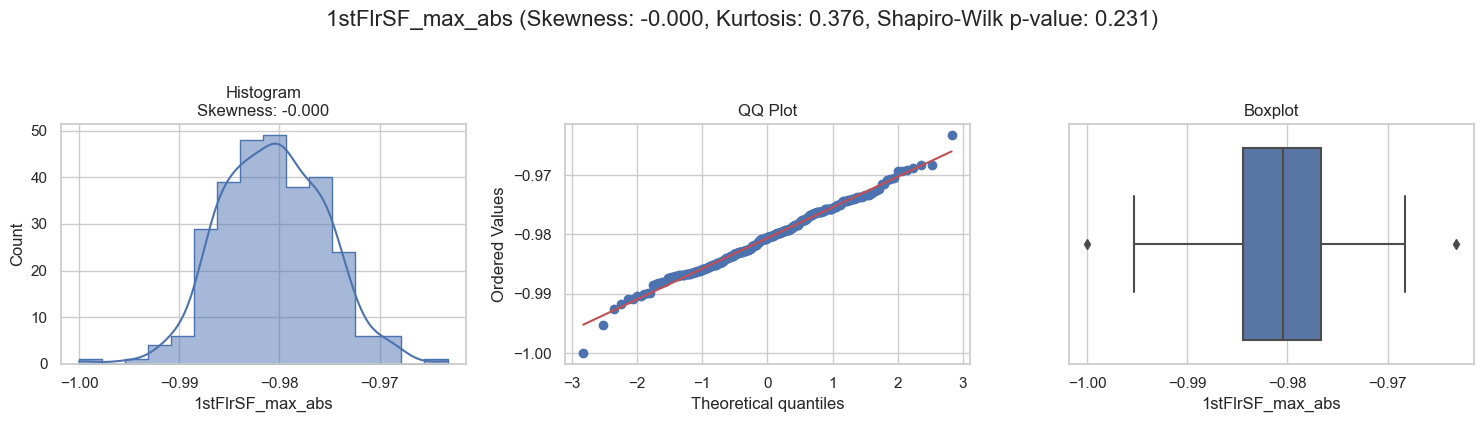

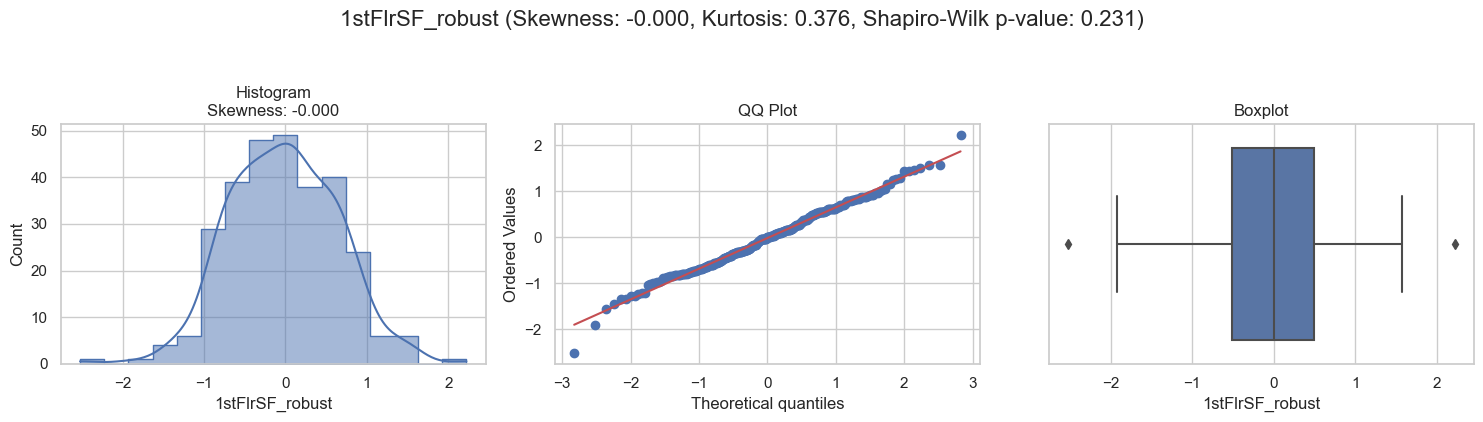

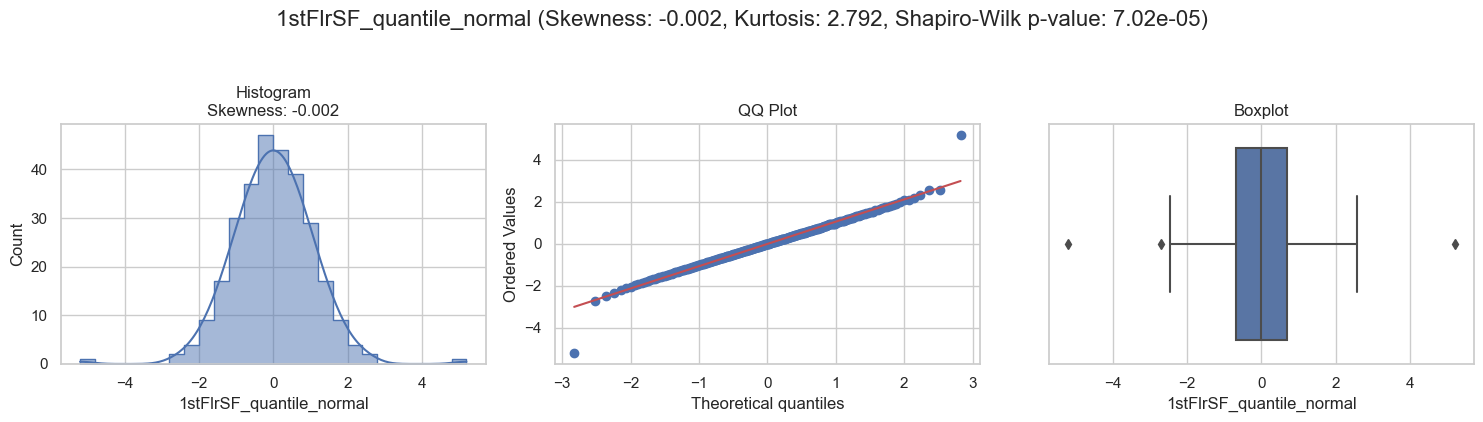

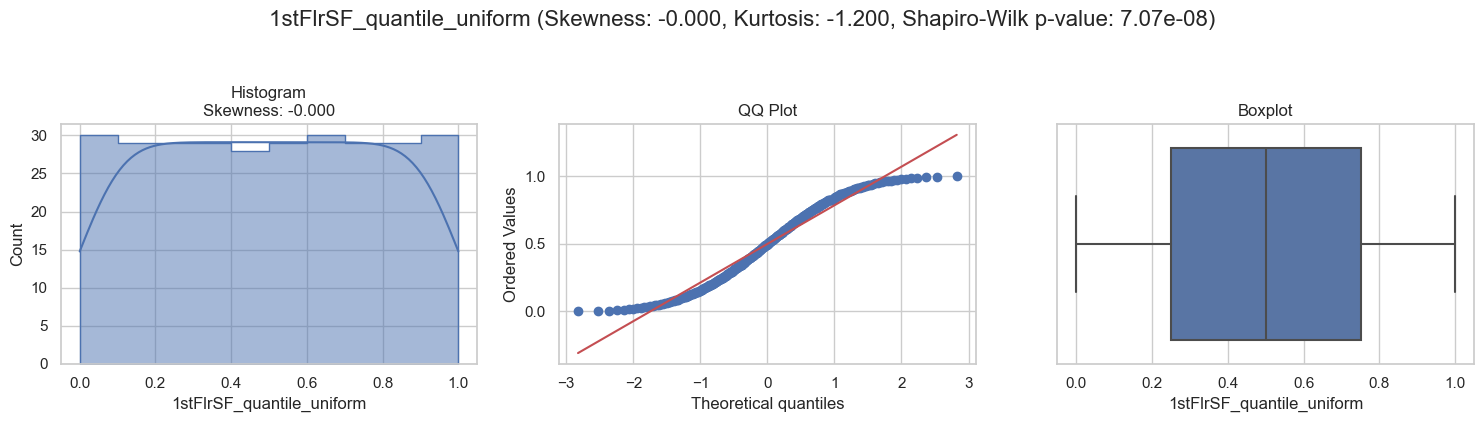

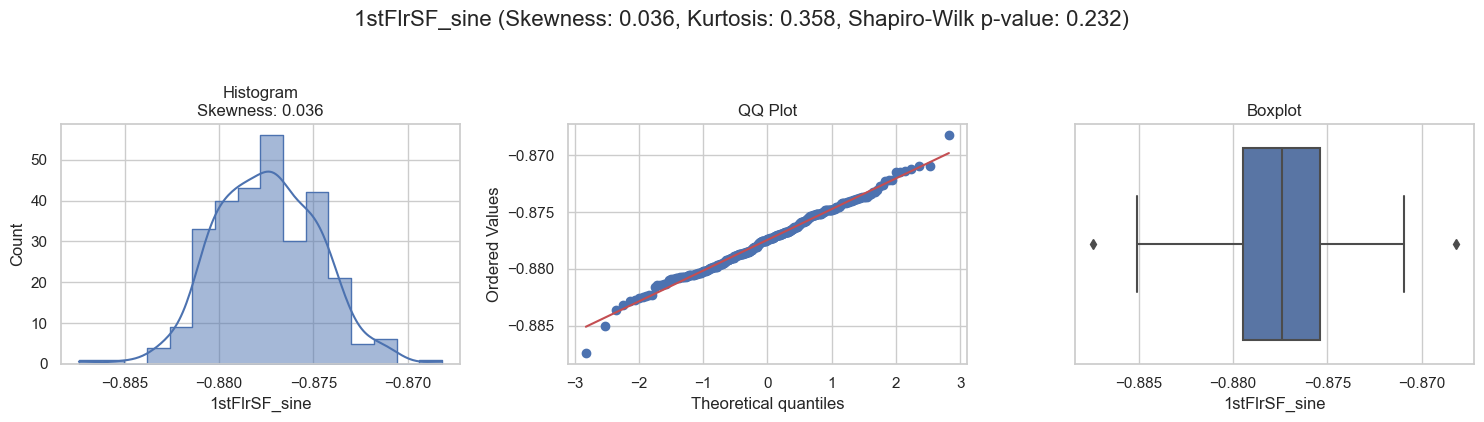

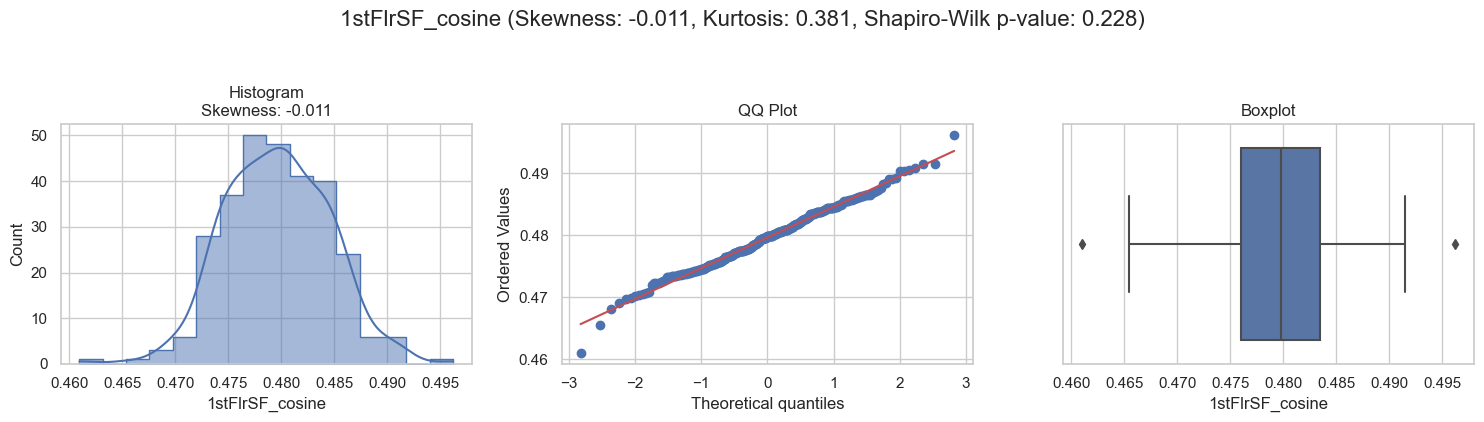



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_yeo_johnson', 'YearBuilt_min_max', 'YearBuilt_max_abs', 'YearBuilt_robust', 'YearBuilt_quantile_normal', 'YearBuilt_quantile_uniform', 'YearBuilt_sine', 'YearBuilt_cosine'] 



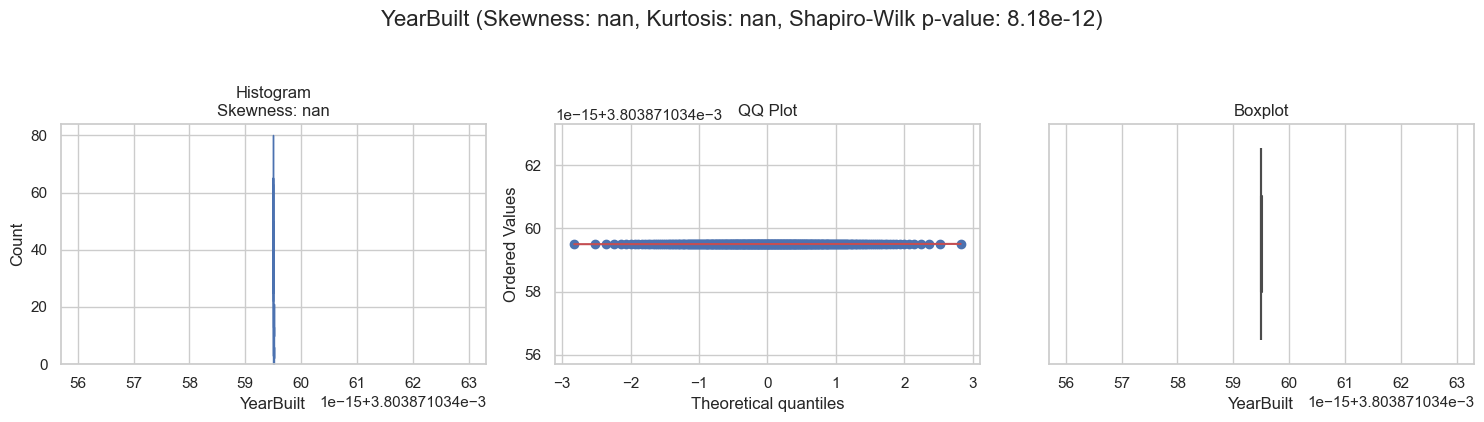

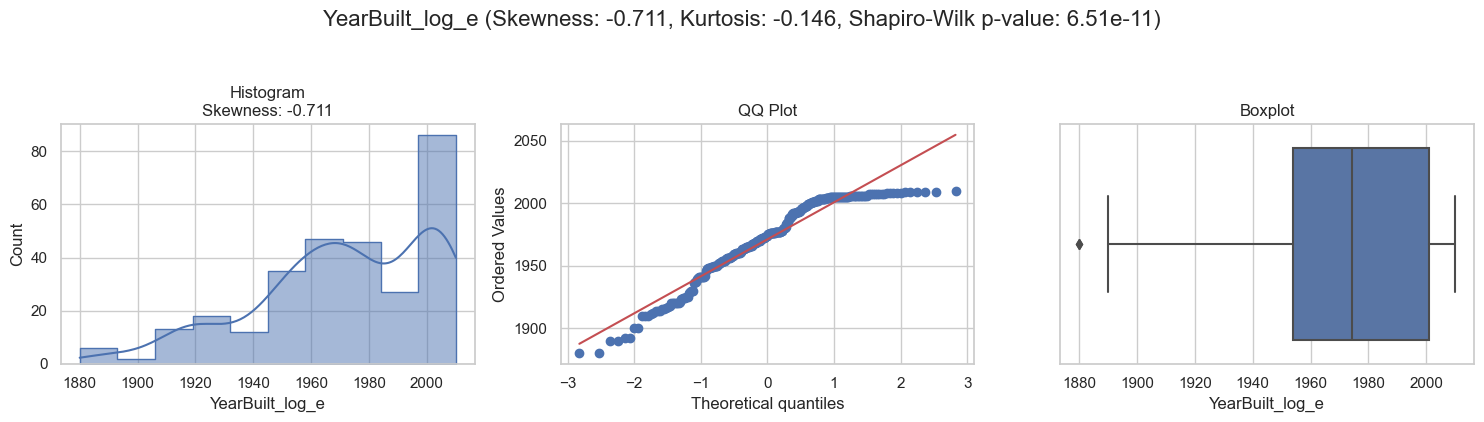

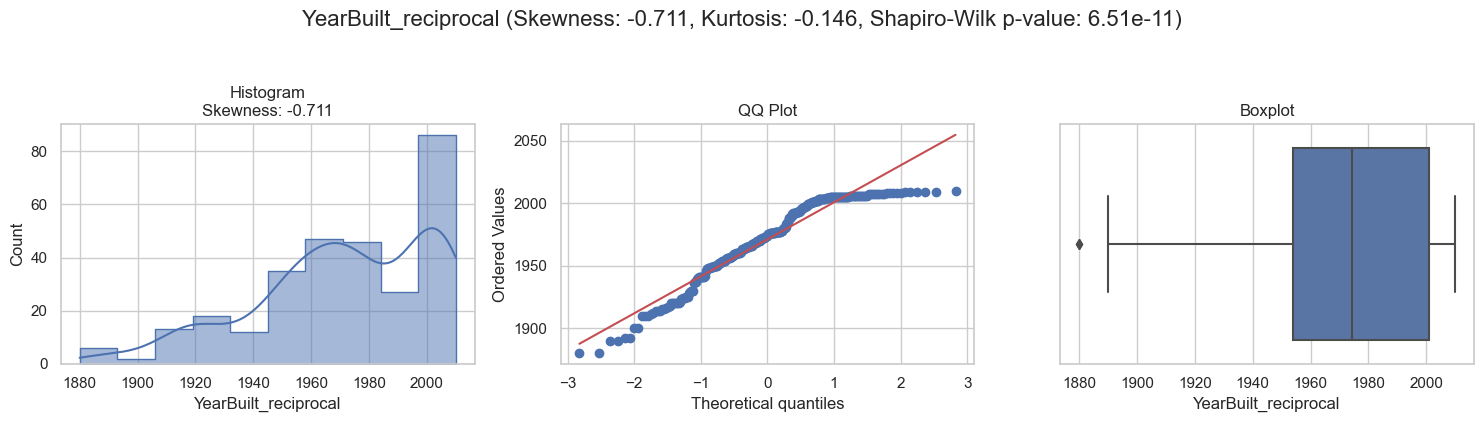

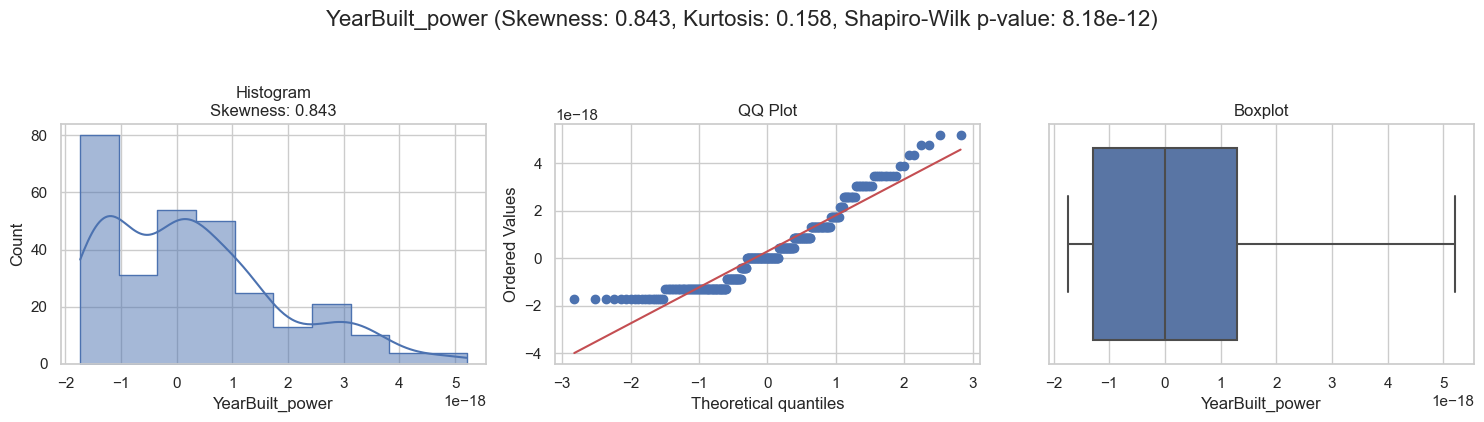

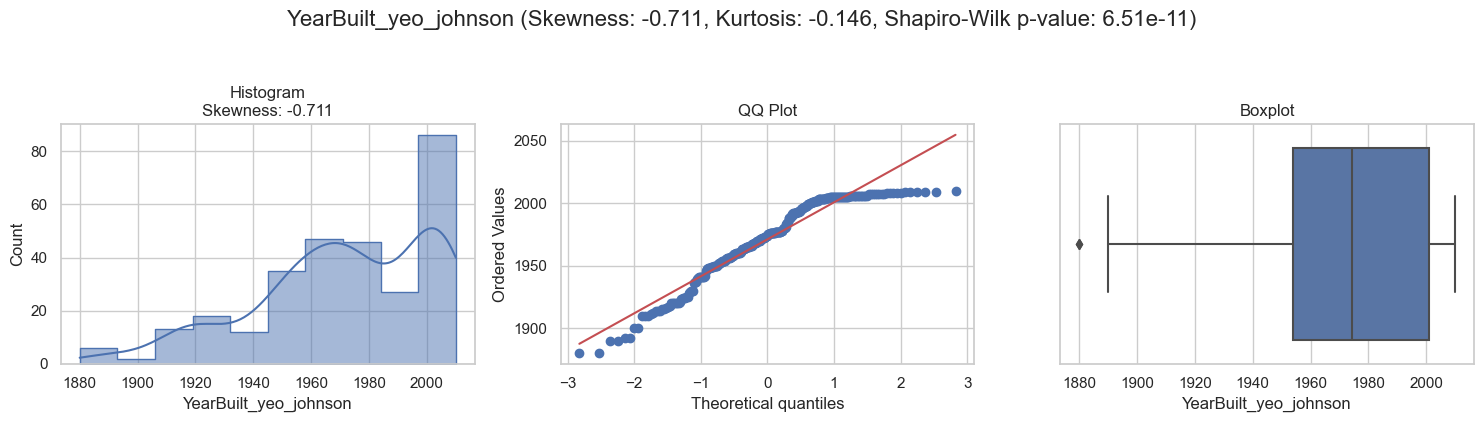

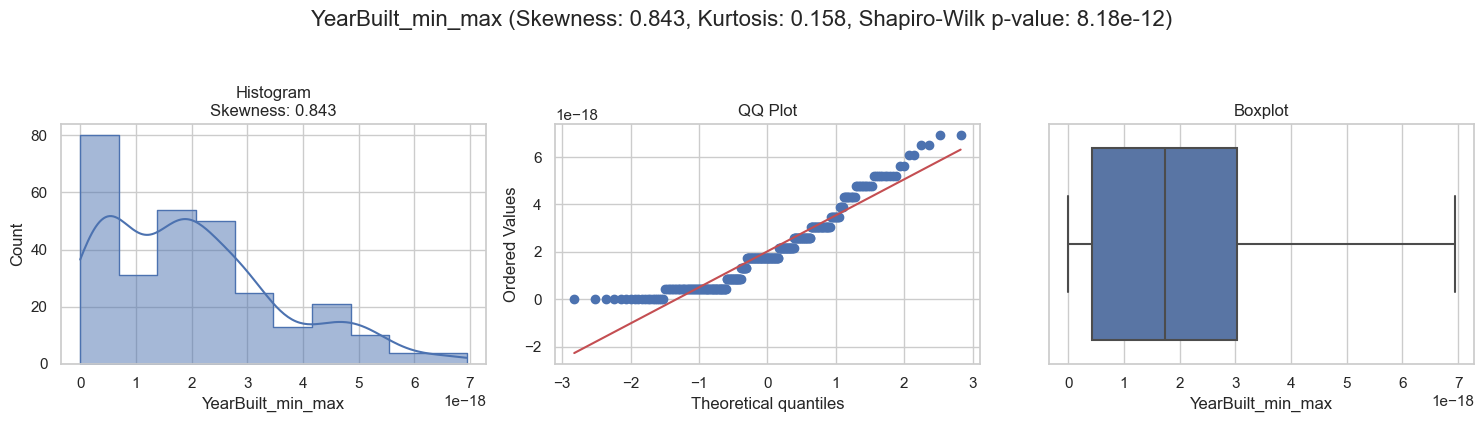

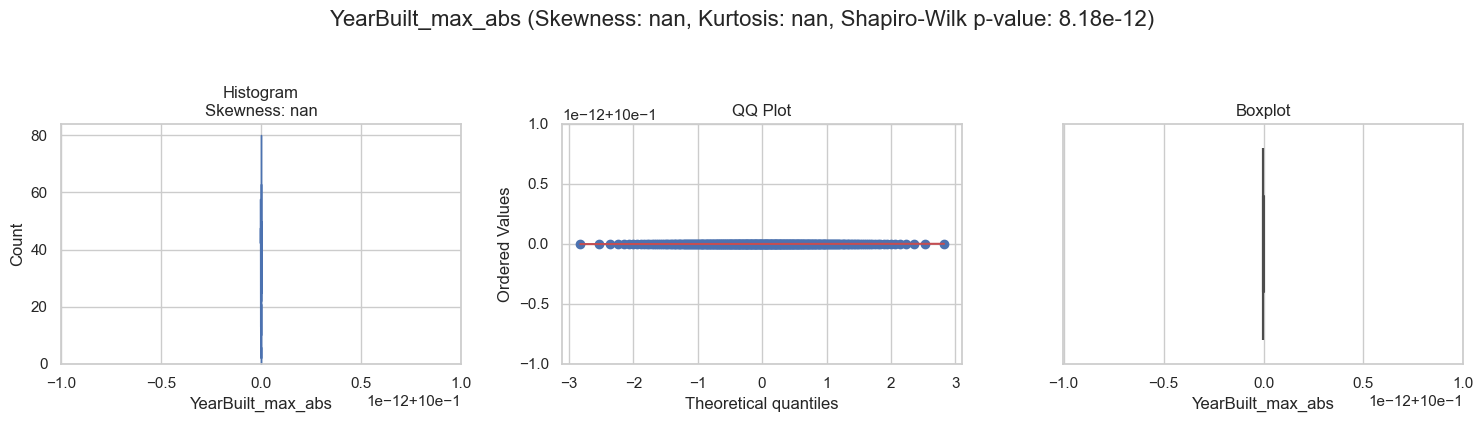

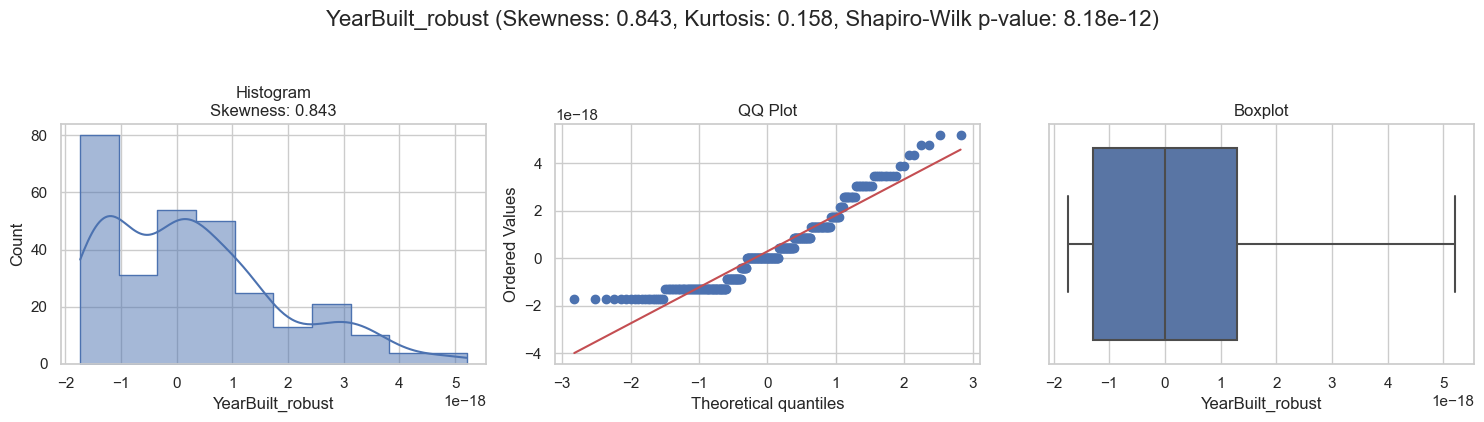

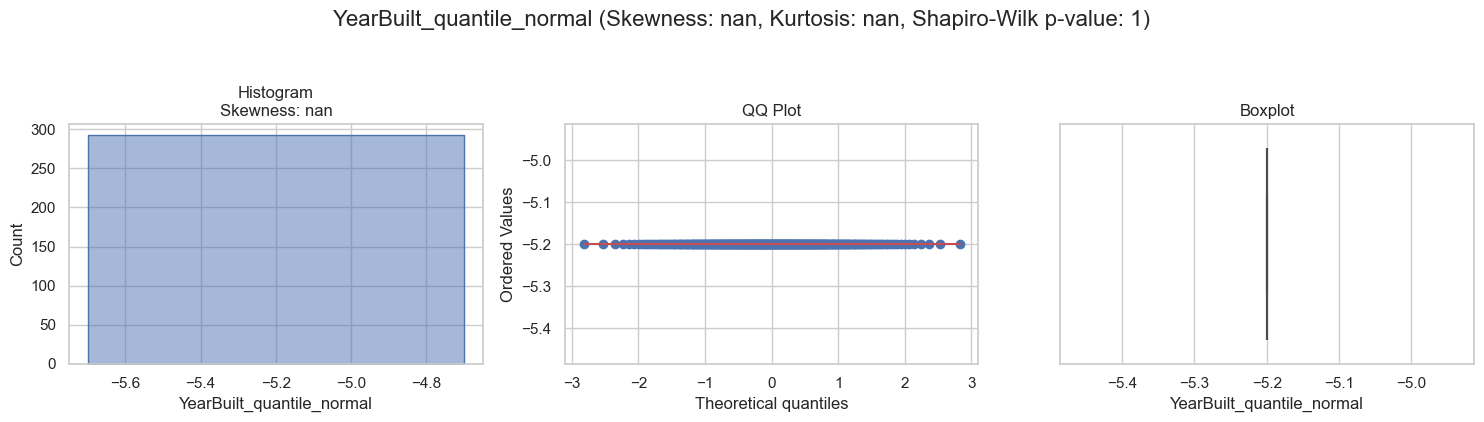

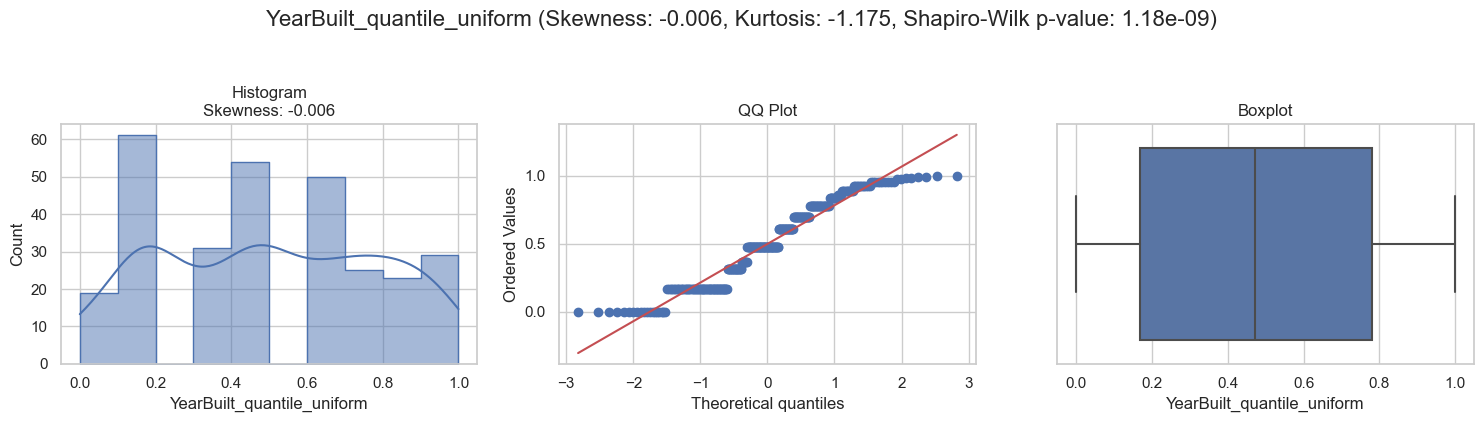

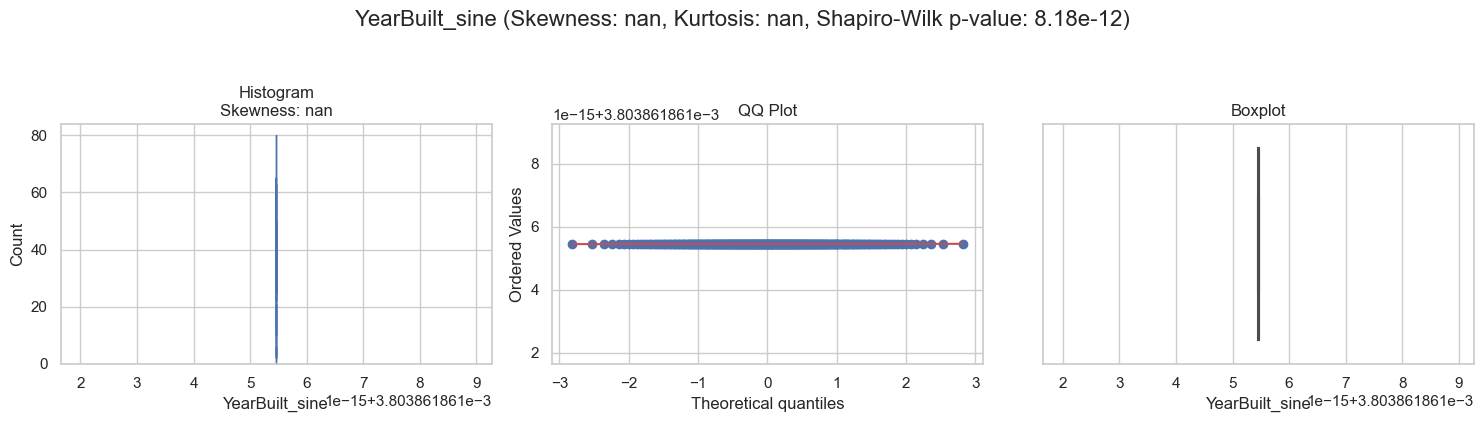

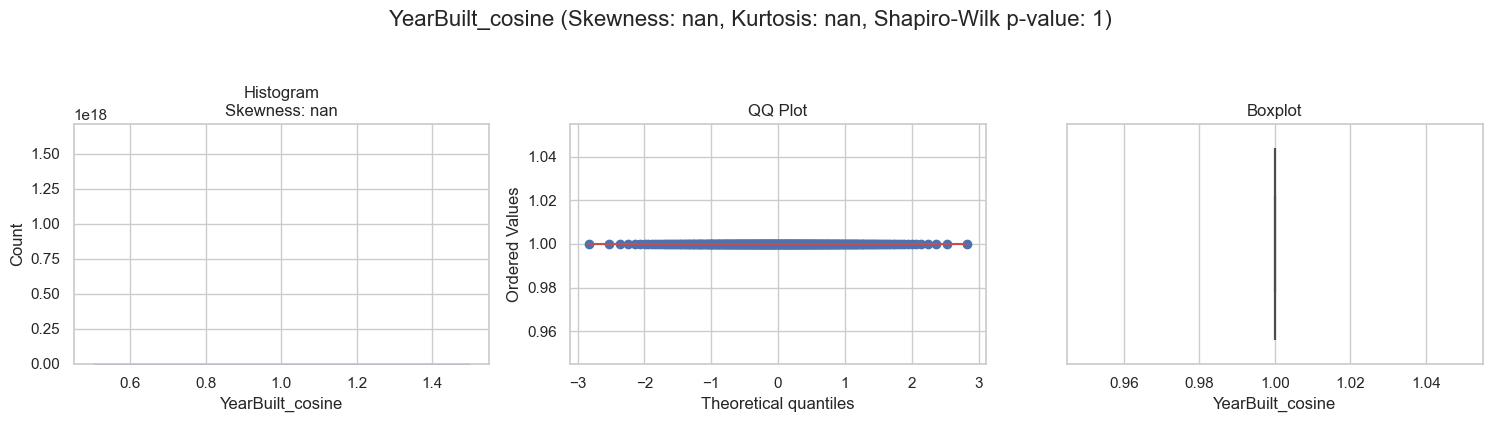



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson', 'GarageArea_min_max', 'GarageArea_max_abs', 'GarageArea_robust', 'GarageArea_quantile_normal', 'GarageArea_quantile_uniform', 'GarageArea_sine', 'GarageArea_cosine'] 



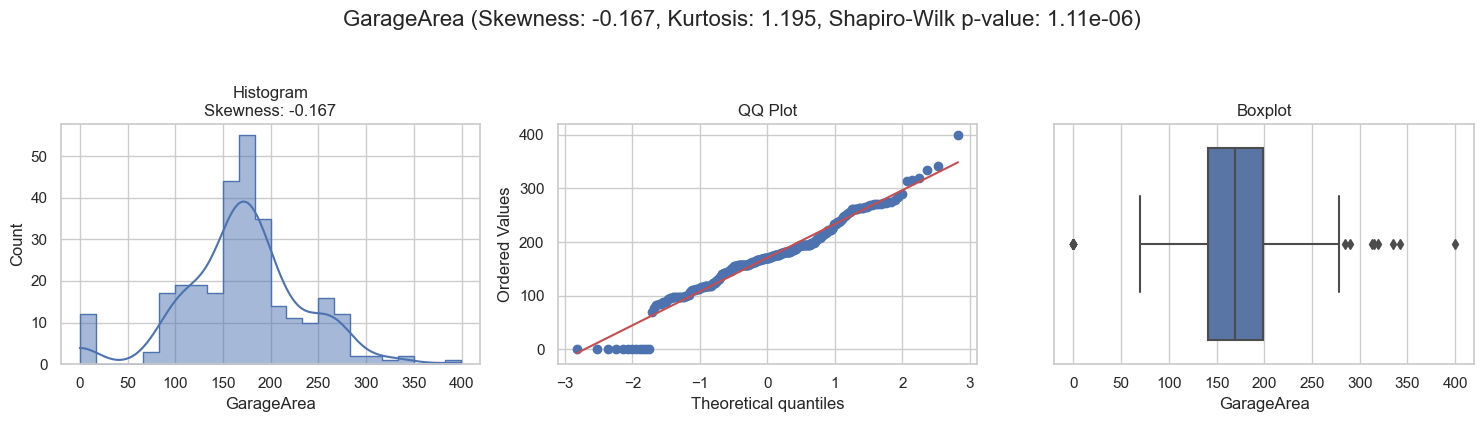

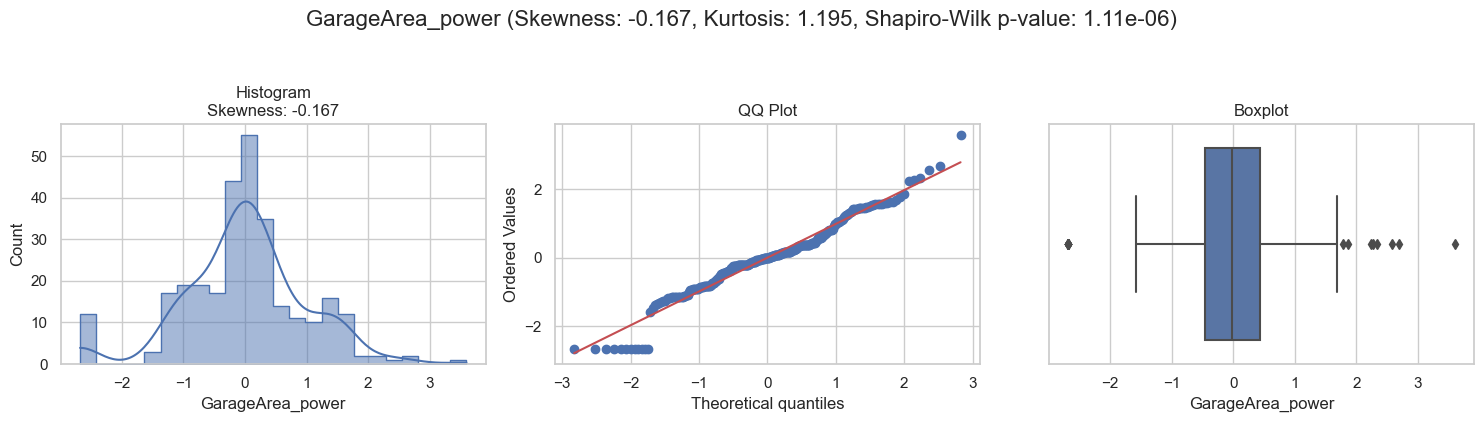

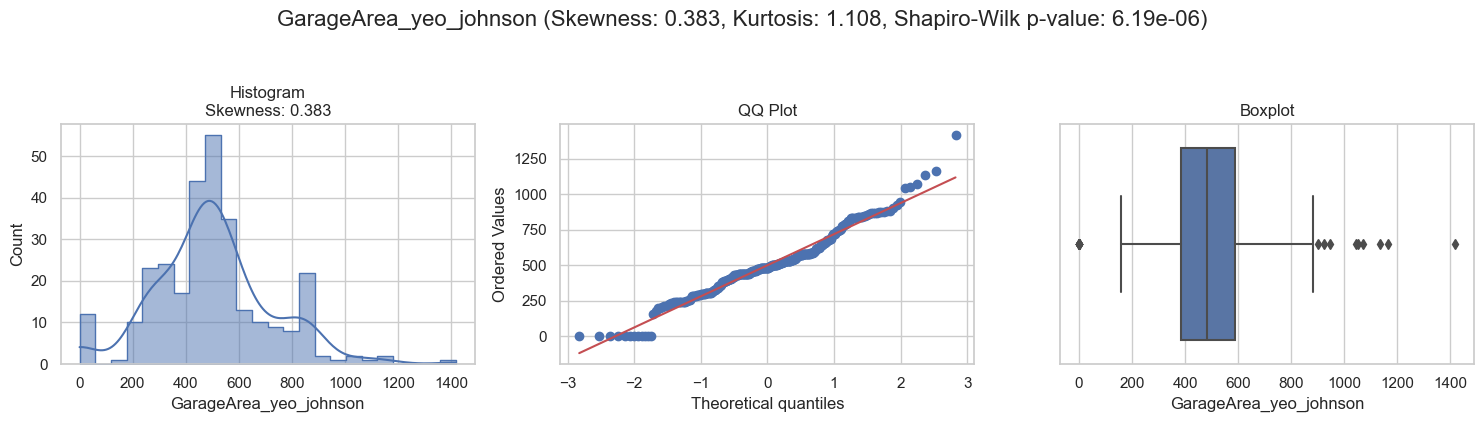

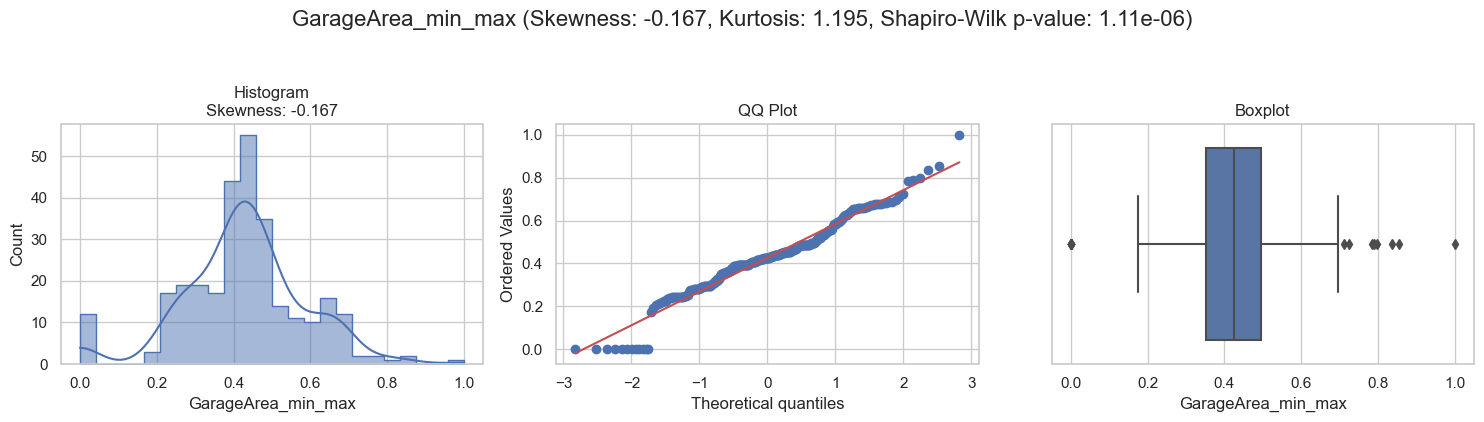

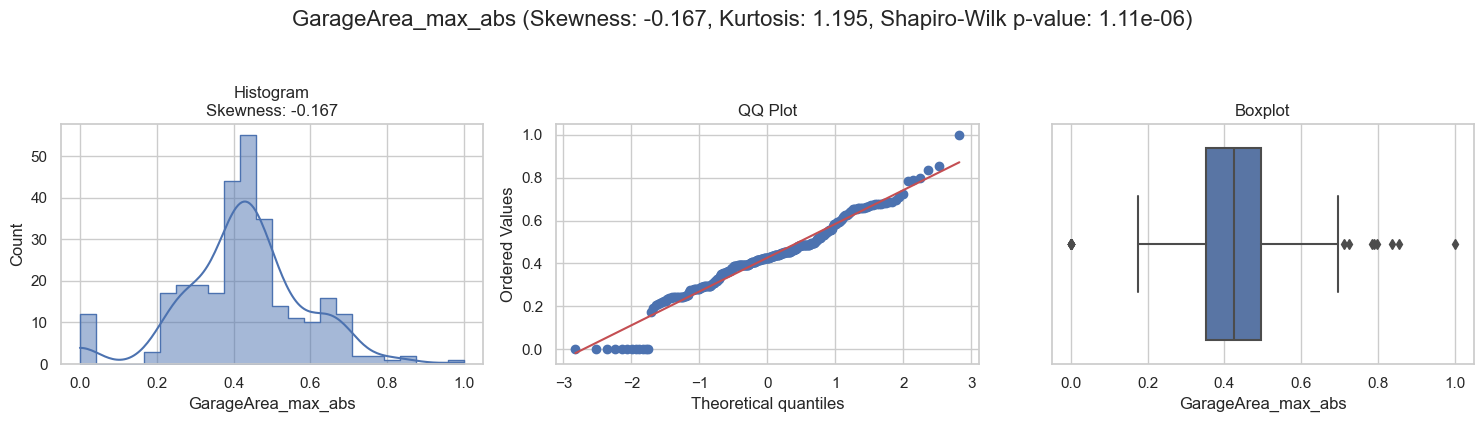

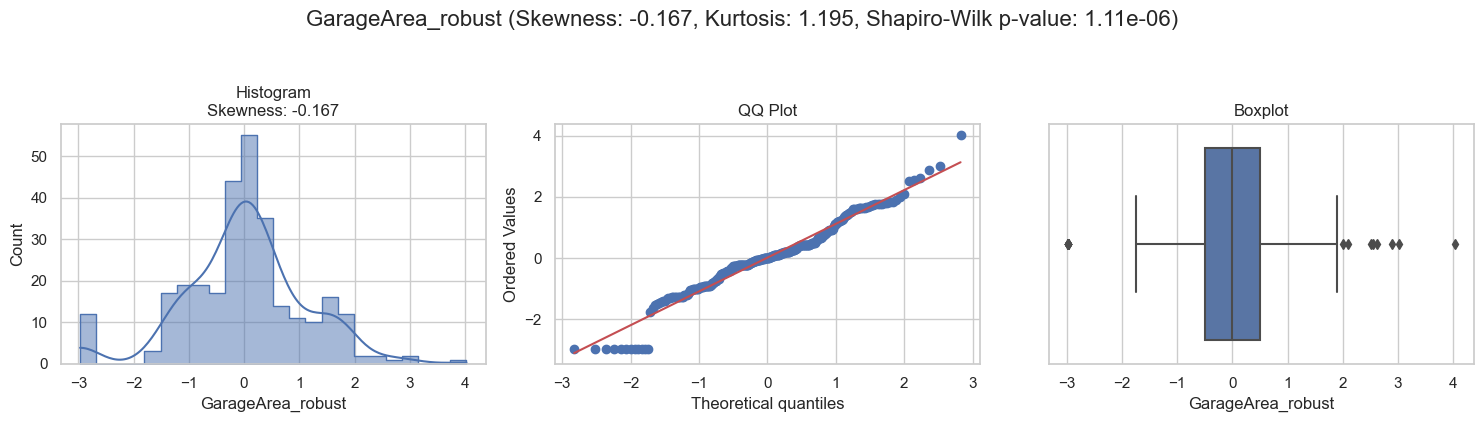

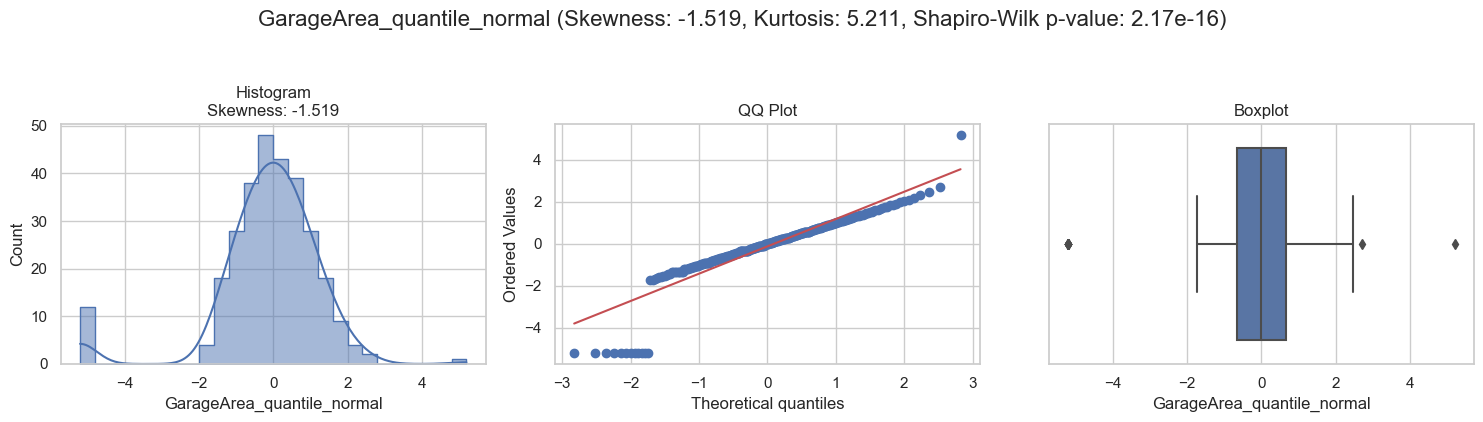

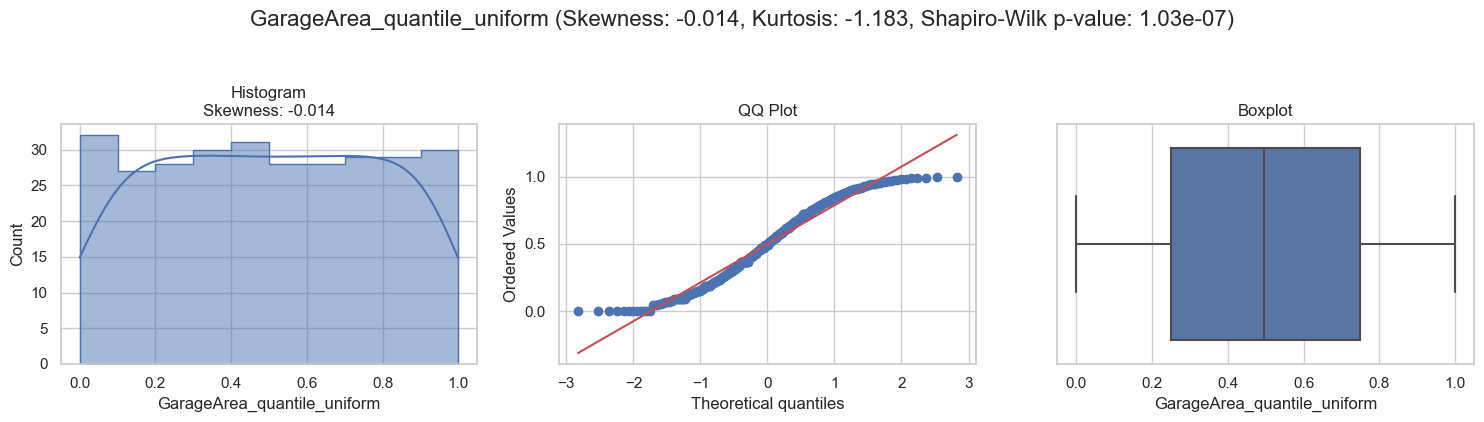

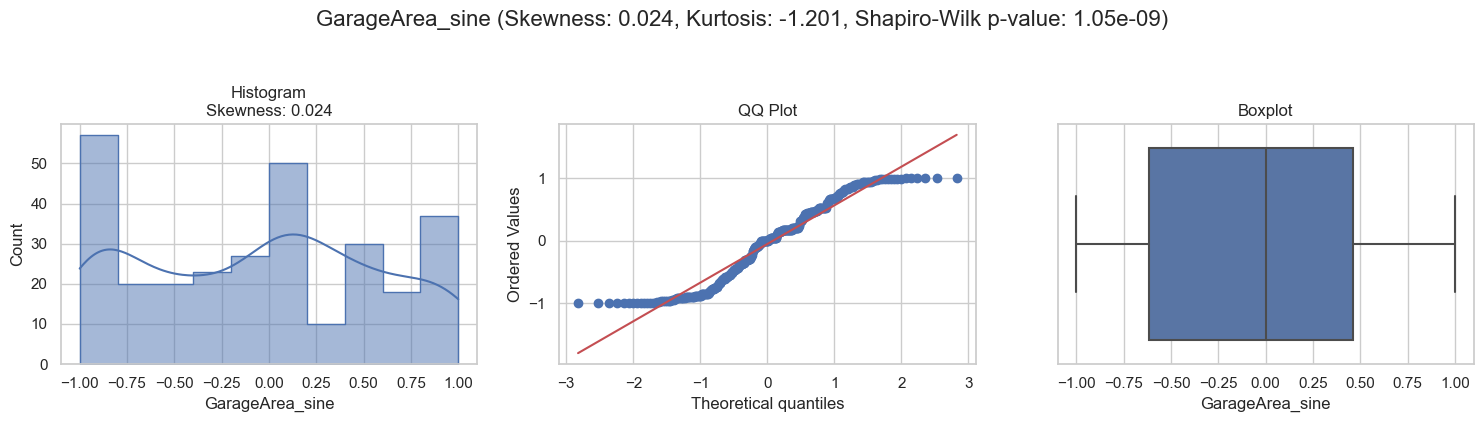

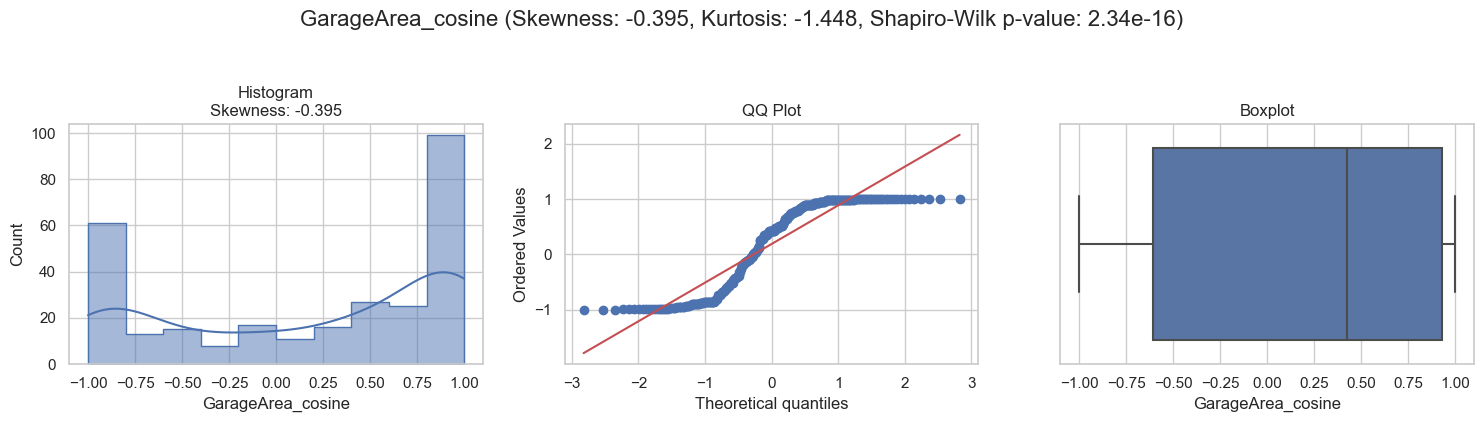



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_log_e', 'GarageYrBlt_reciprocal', 'GarageYrBlt_power', 'GarageYrBlt_box_cox', 'GarageYrBlt_min_max', 'GarageYrBlt_max_abs', 'GarageYrBlt_robust', 'GarageYrBlt_quantile_normal', 'GarageYrBlt_quantile_uniform', 'GarageYrBlt_sine', 'GarageYrBlt_cosine'] 



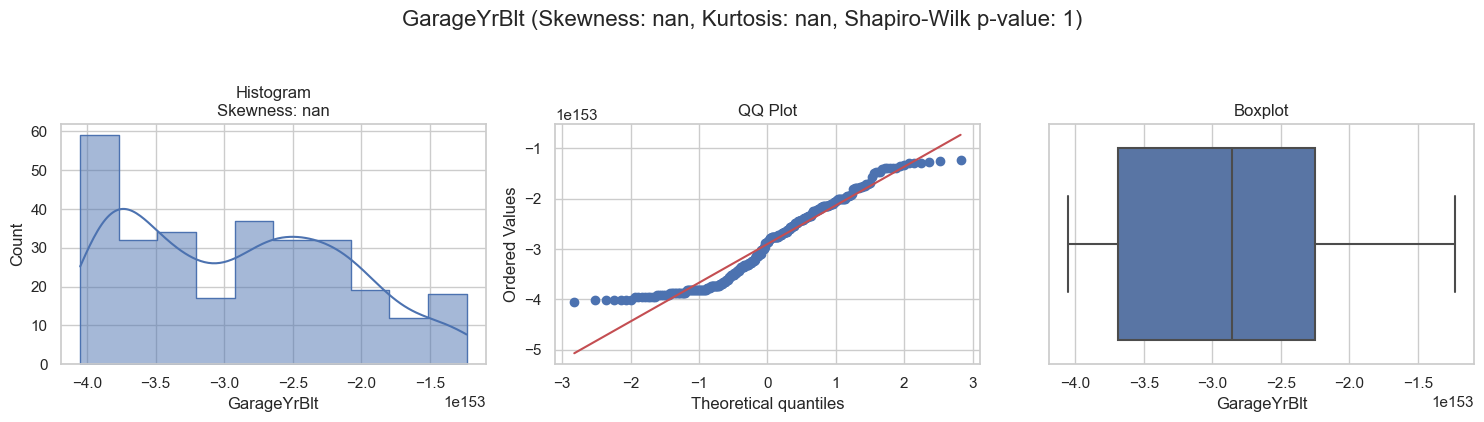

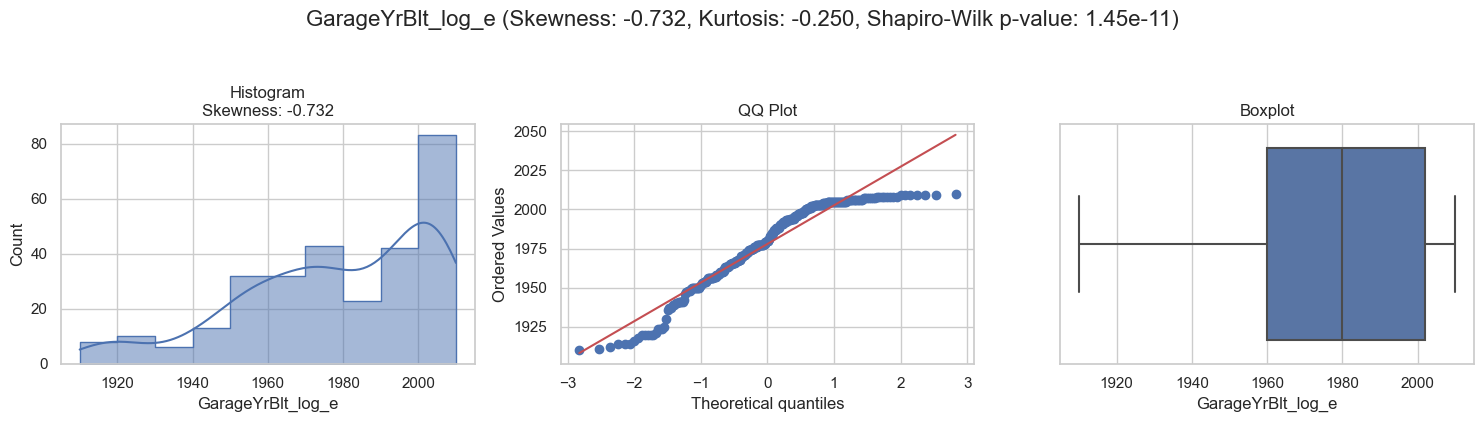

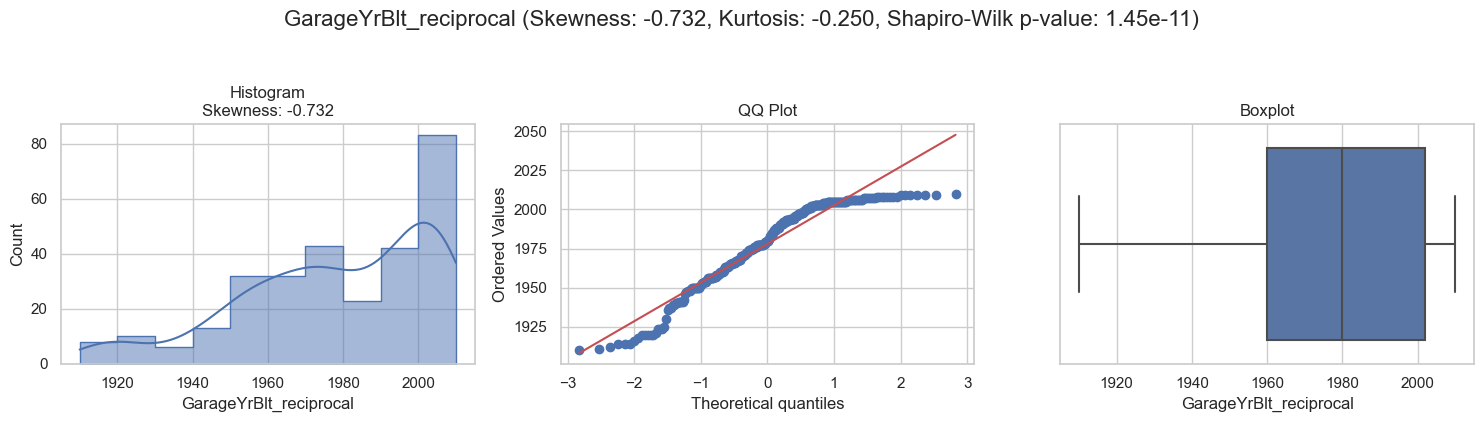

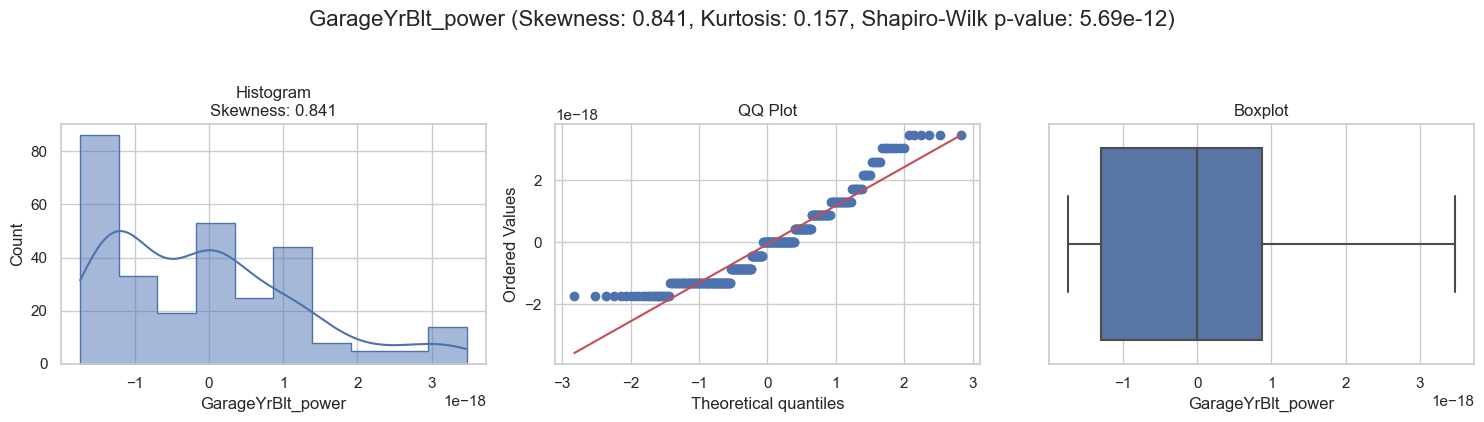

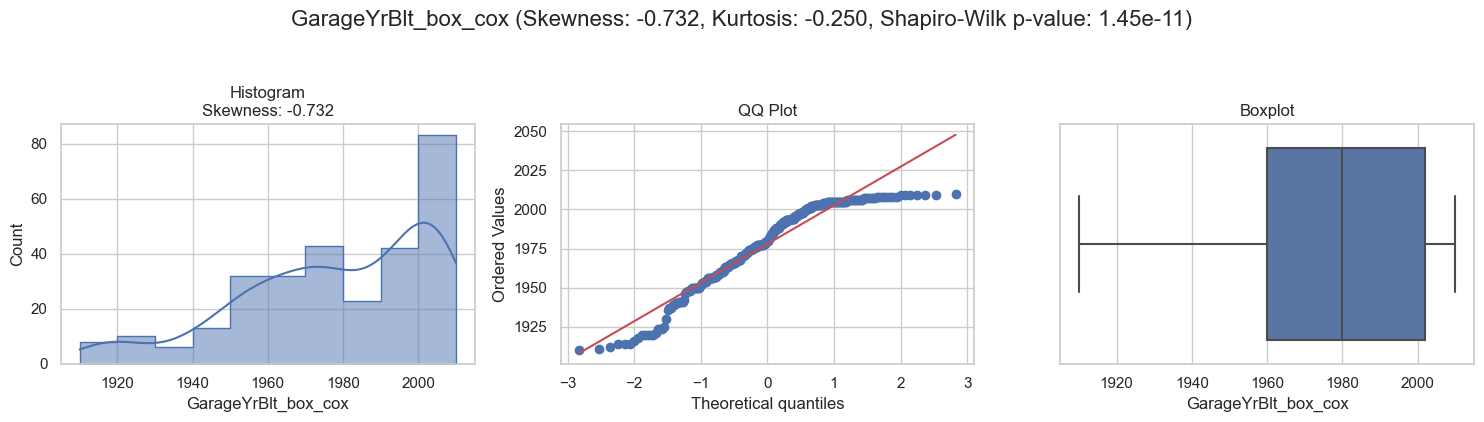

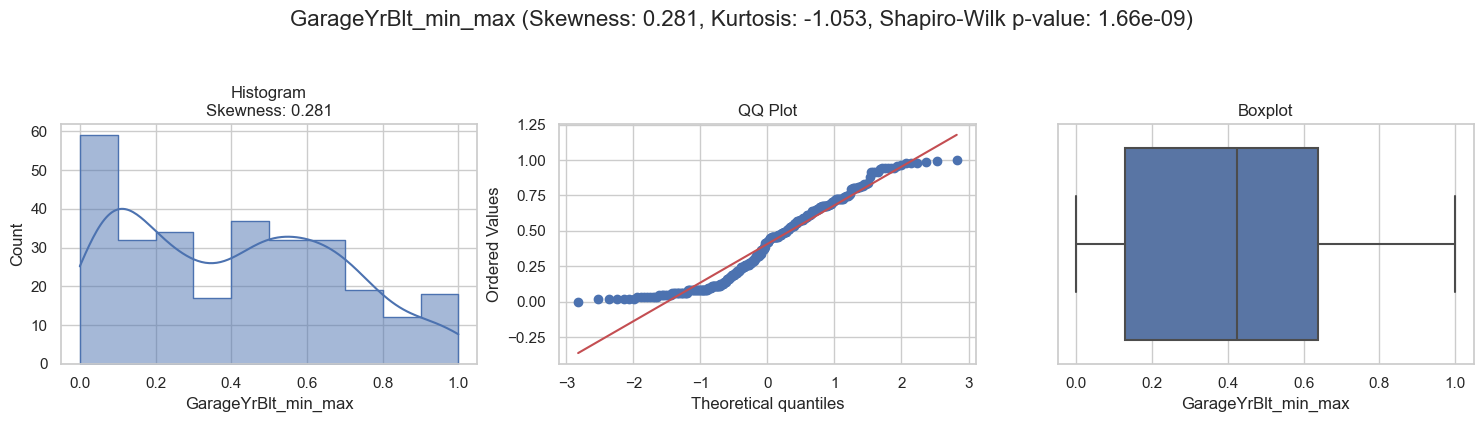

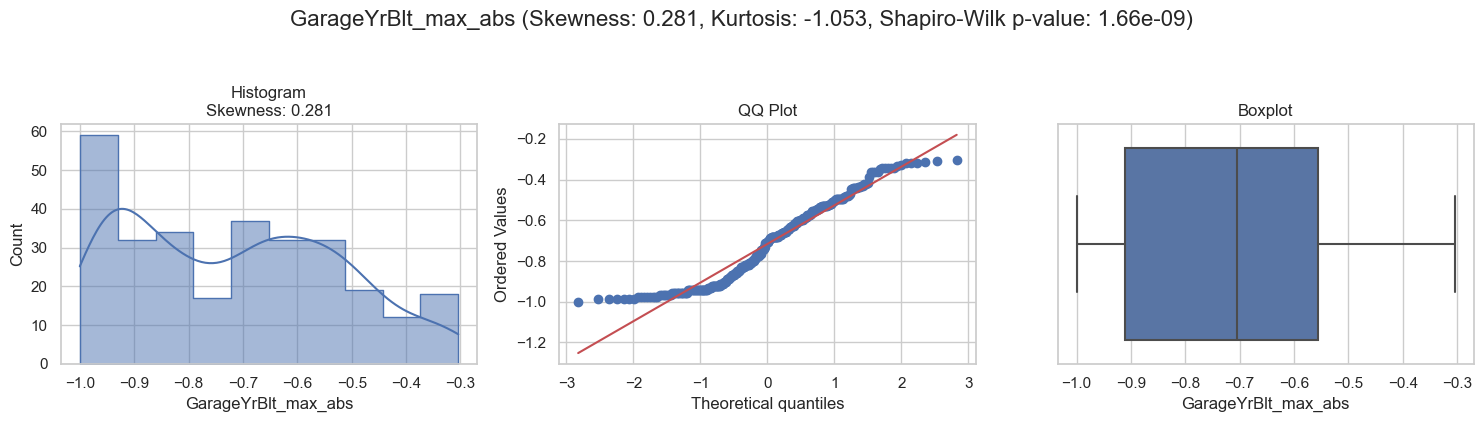

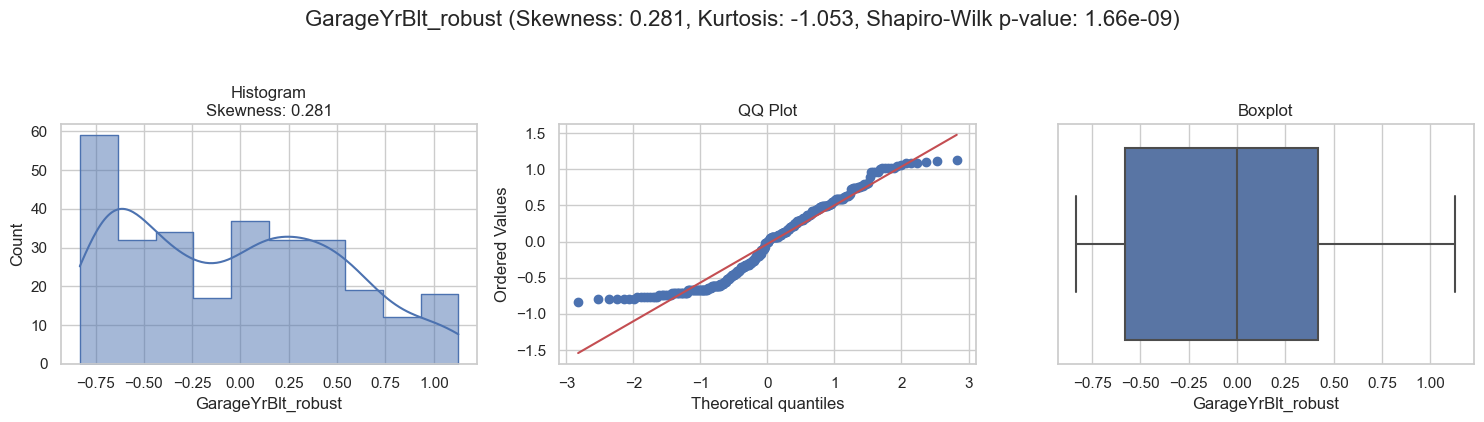

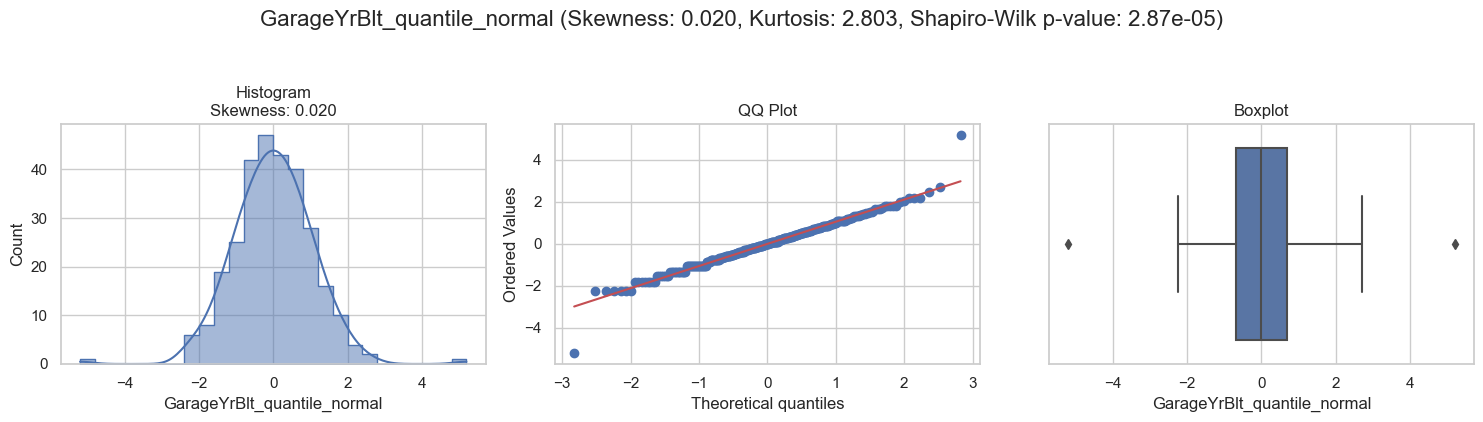

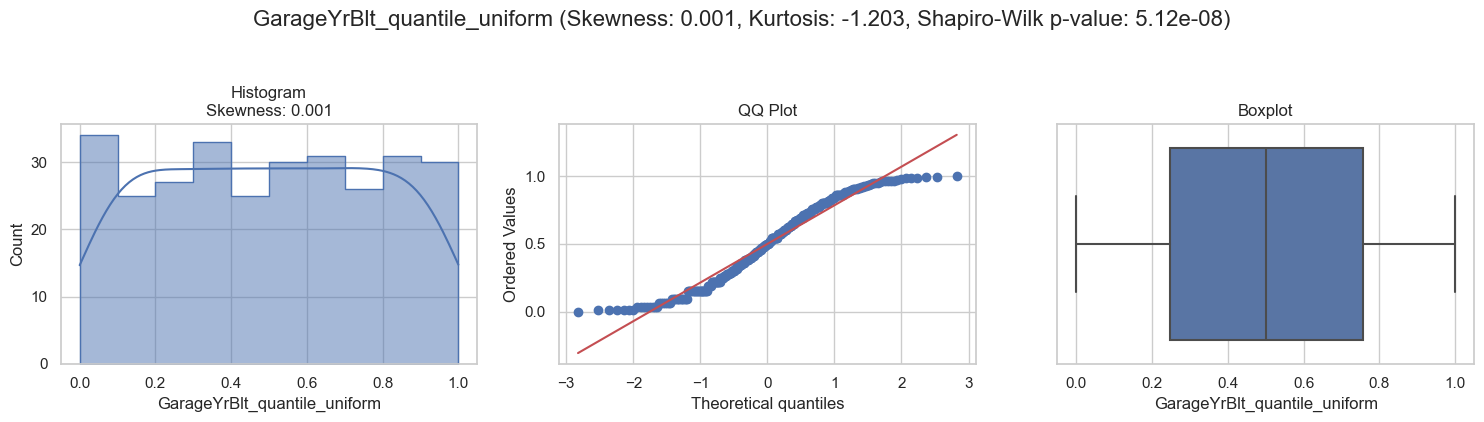

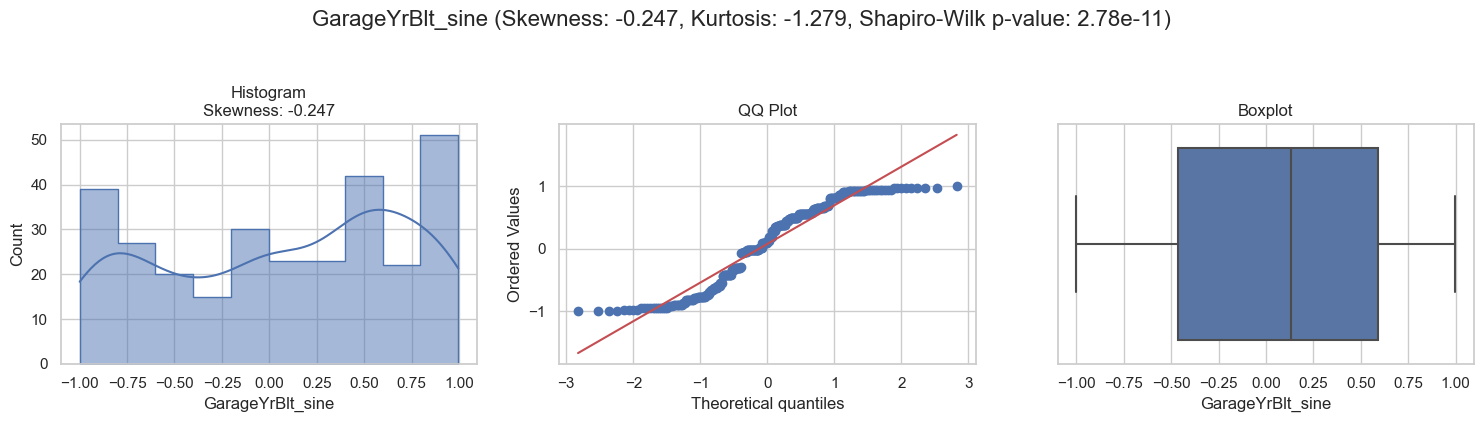

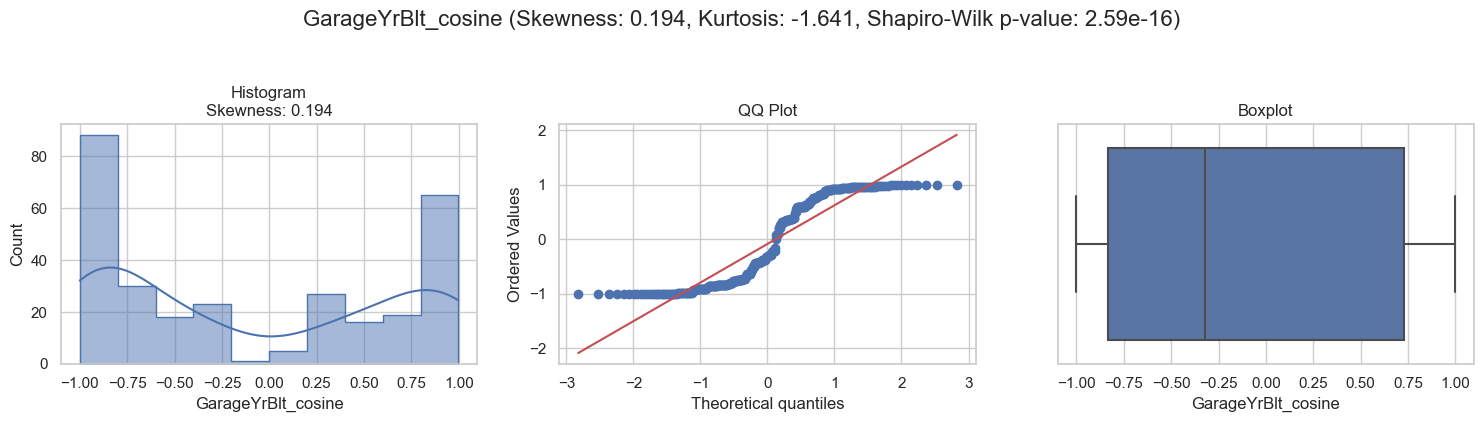



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson', 'OverallQual_min_max', 'OverallQual_max_abs', 'OverallQual_robust', 'OverallQual_quantile_normal', 'OverallQual_quantile_uniform', 'OverallQual_sine', 'OverallQual_cosine'] 



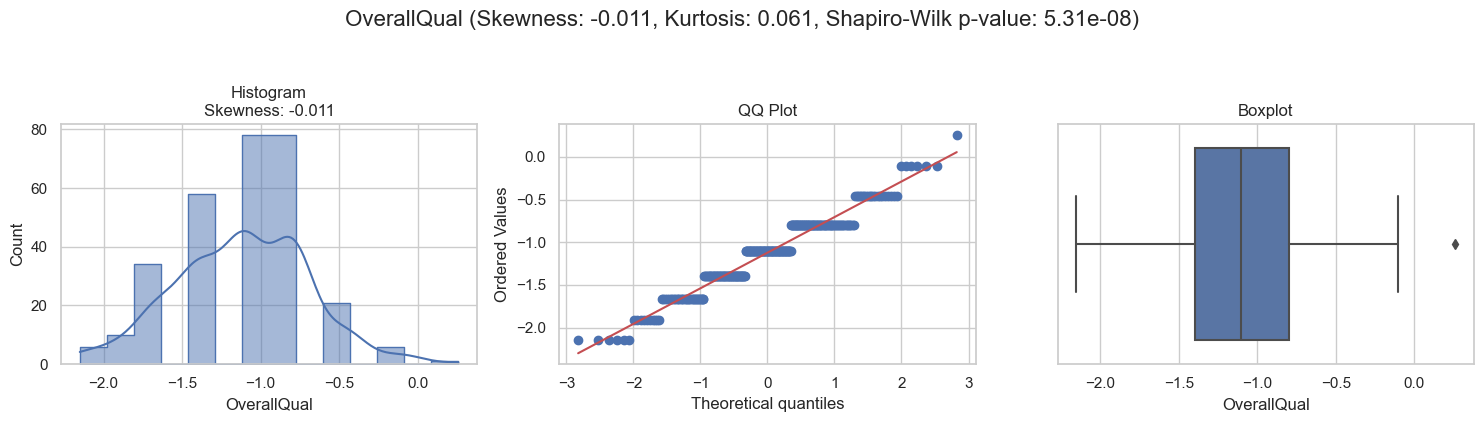

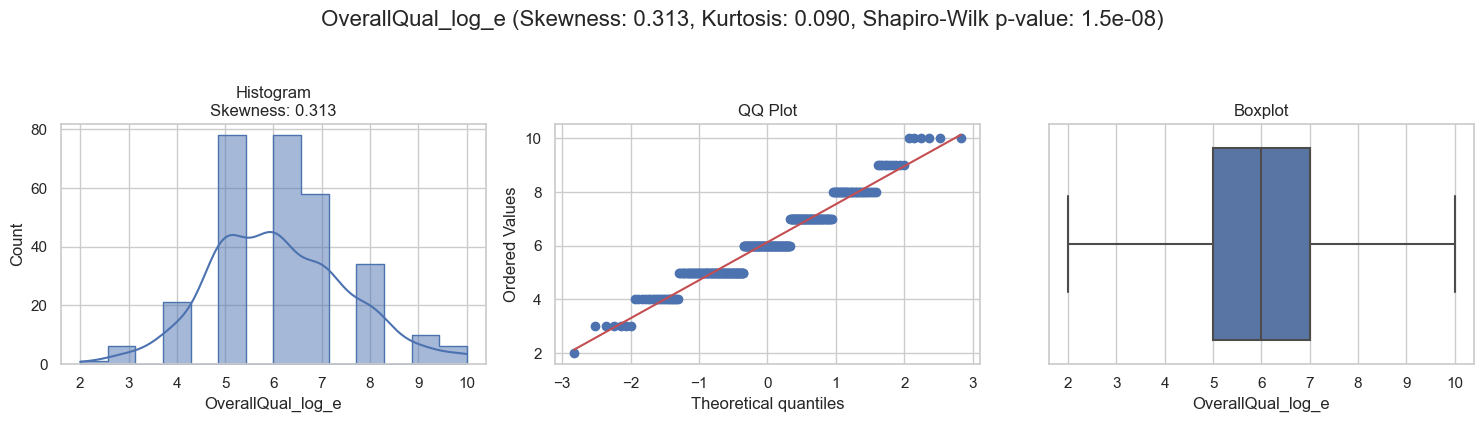

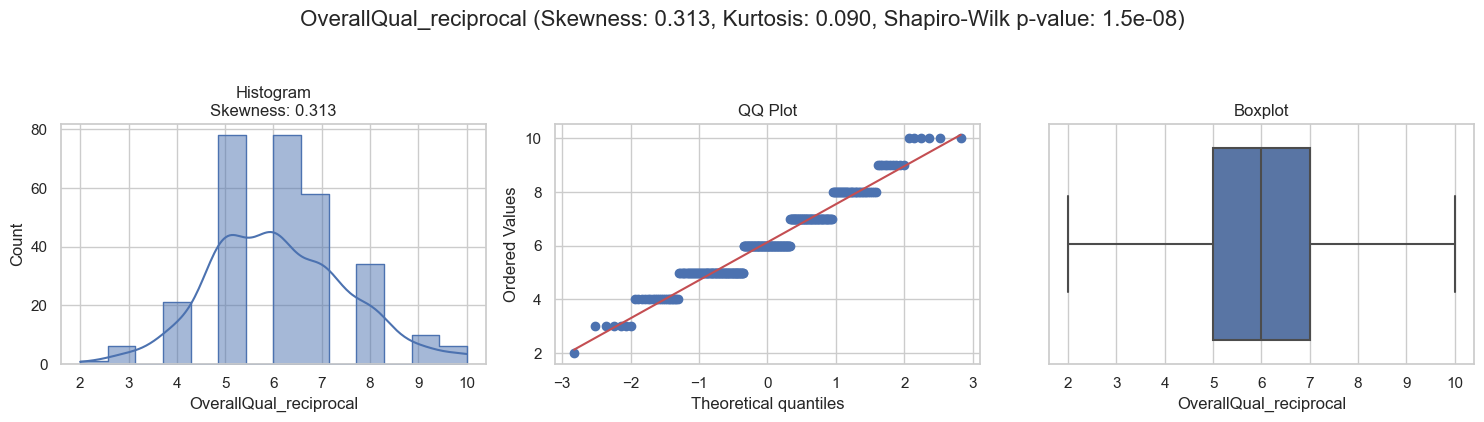

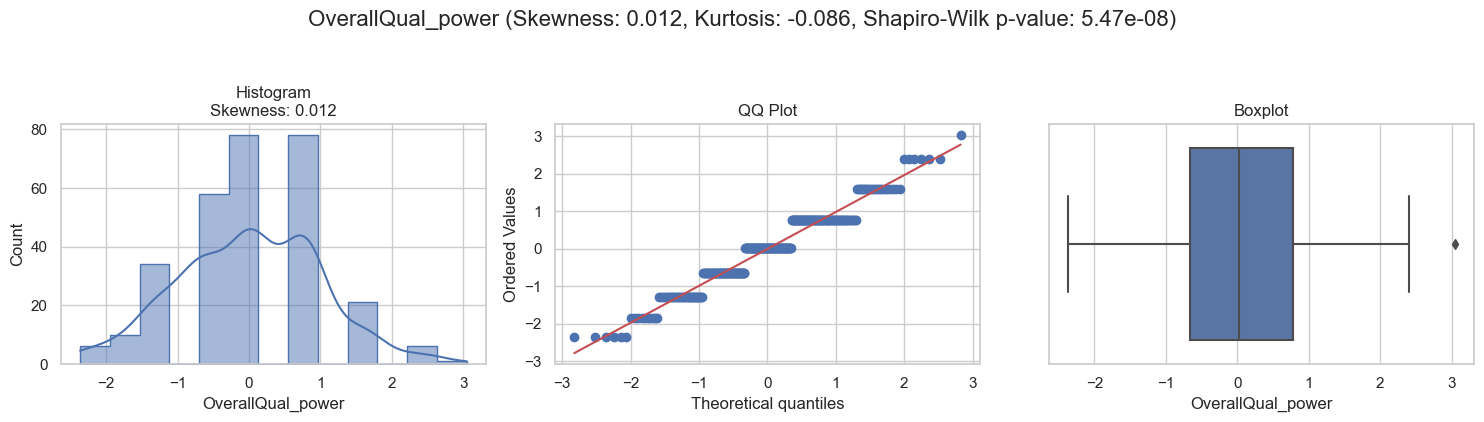

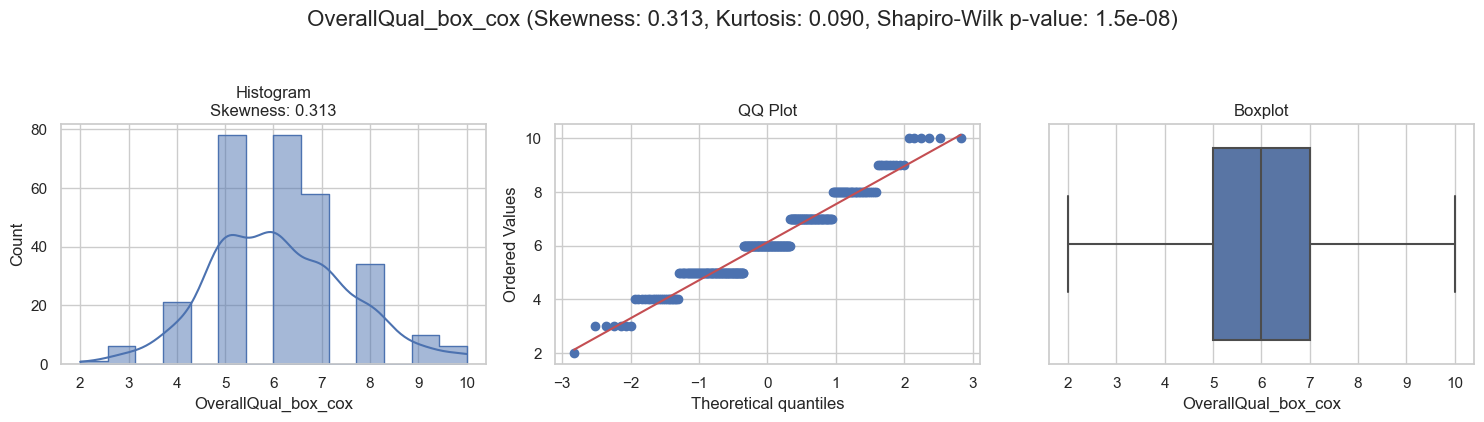

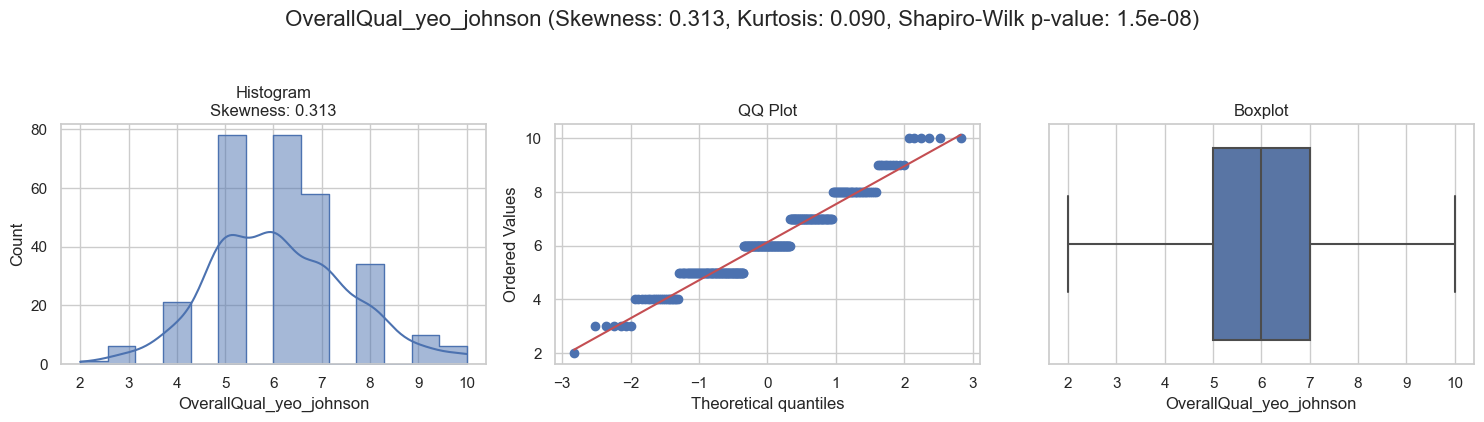

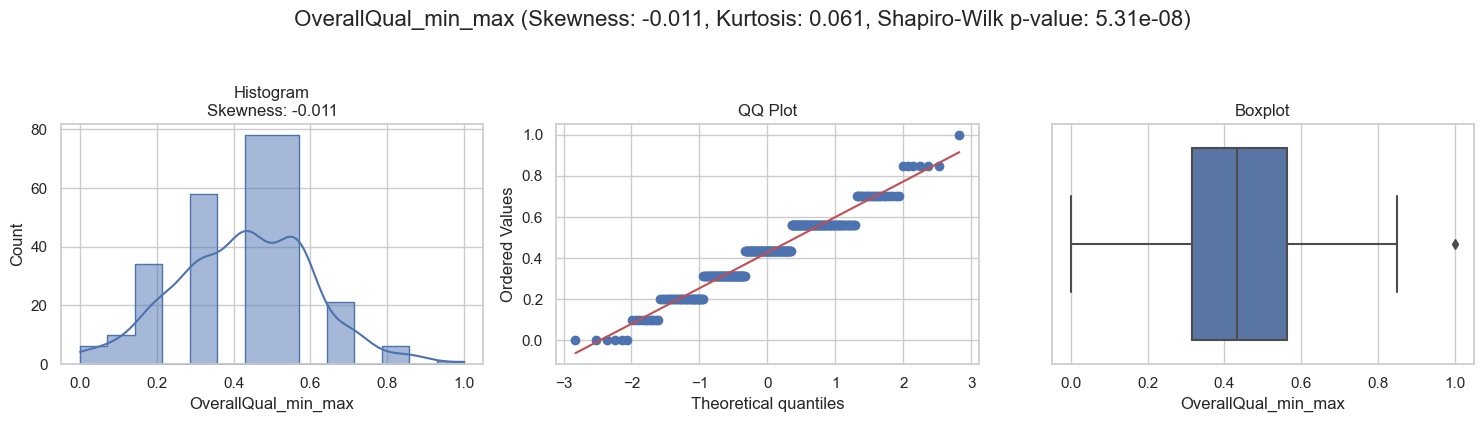

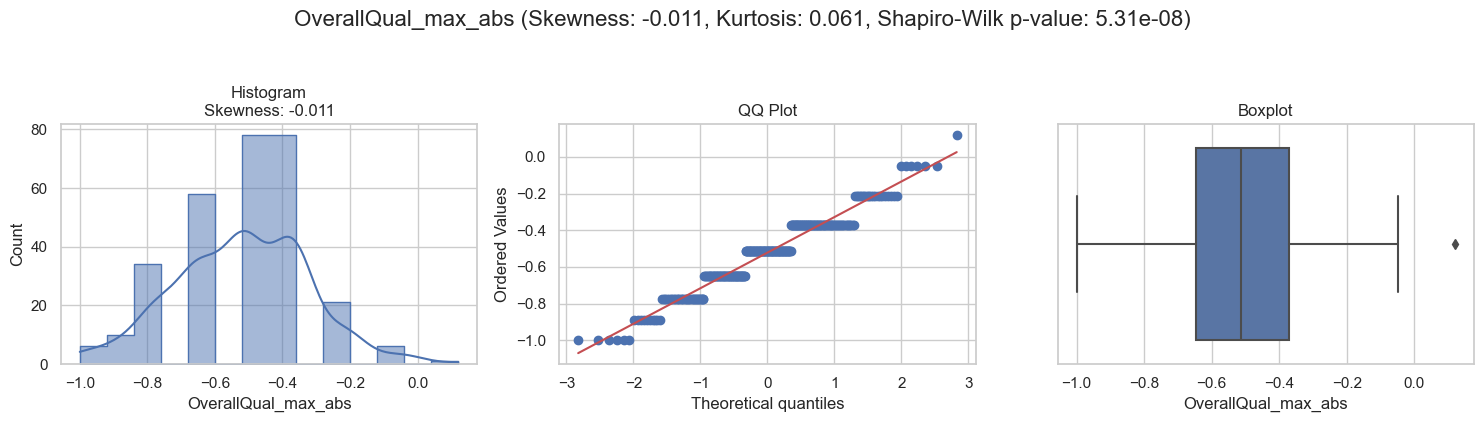

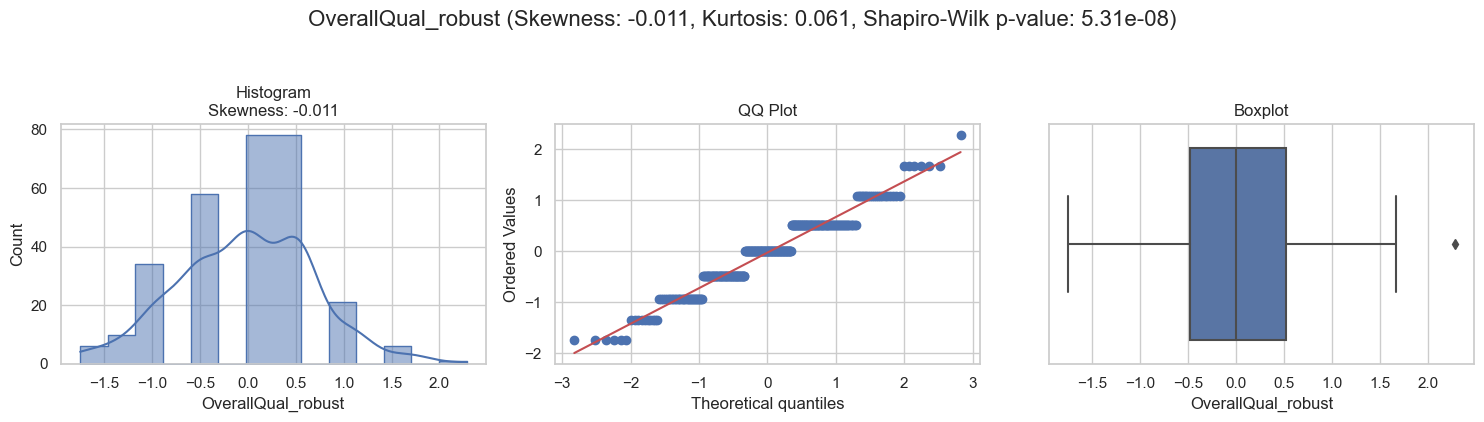

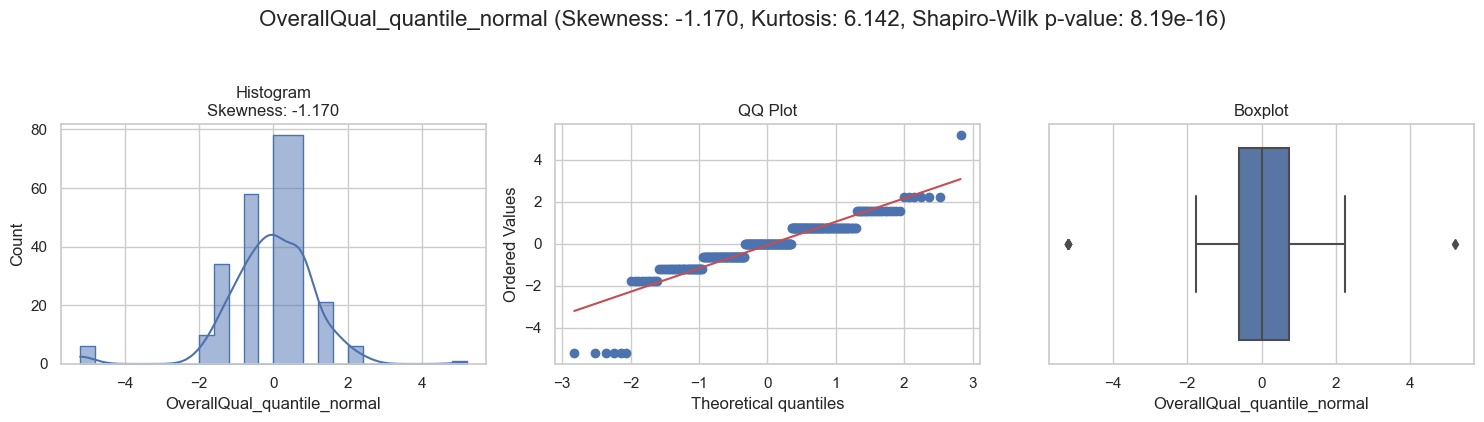

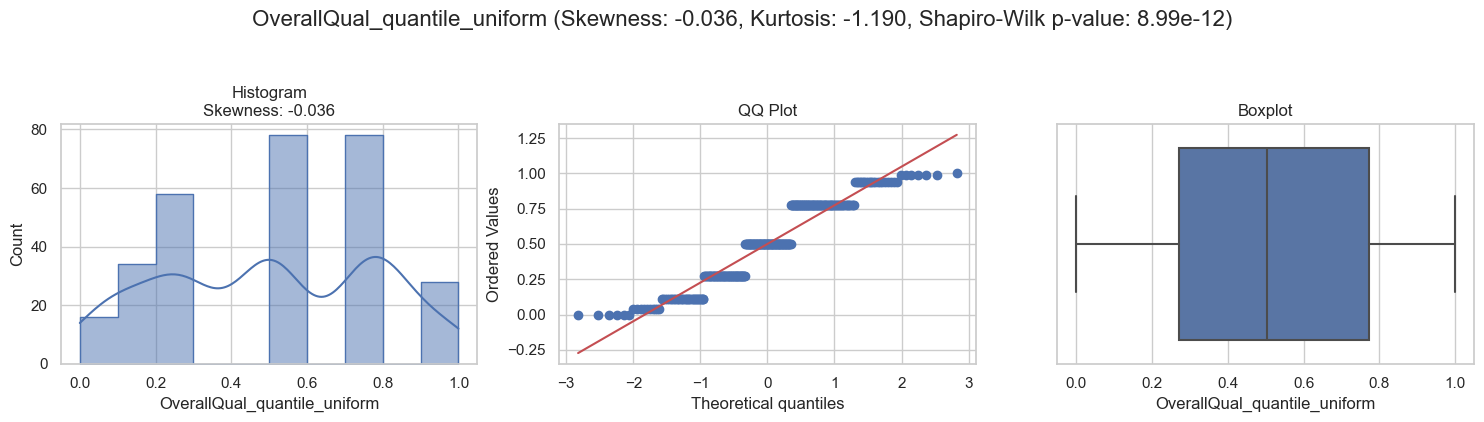

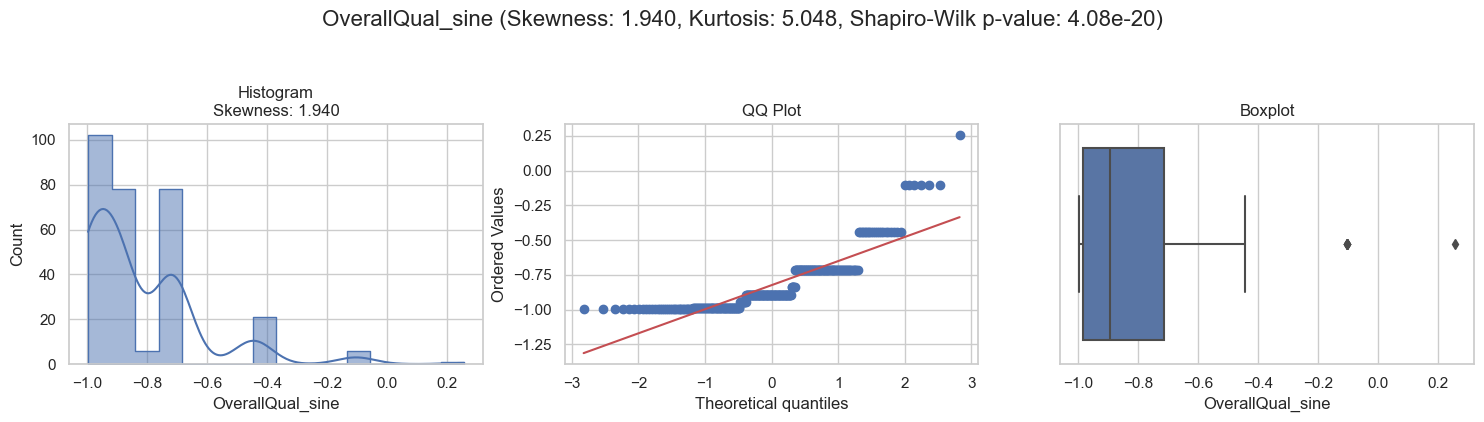

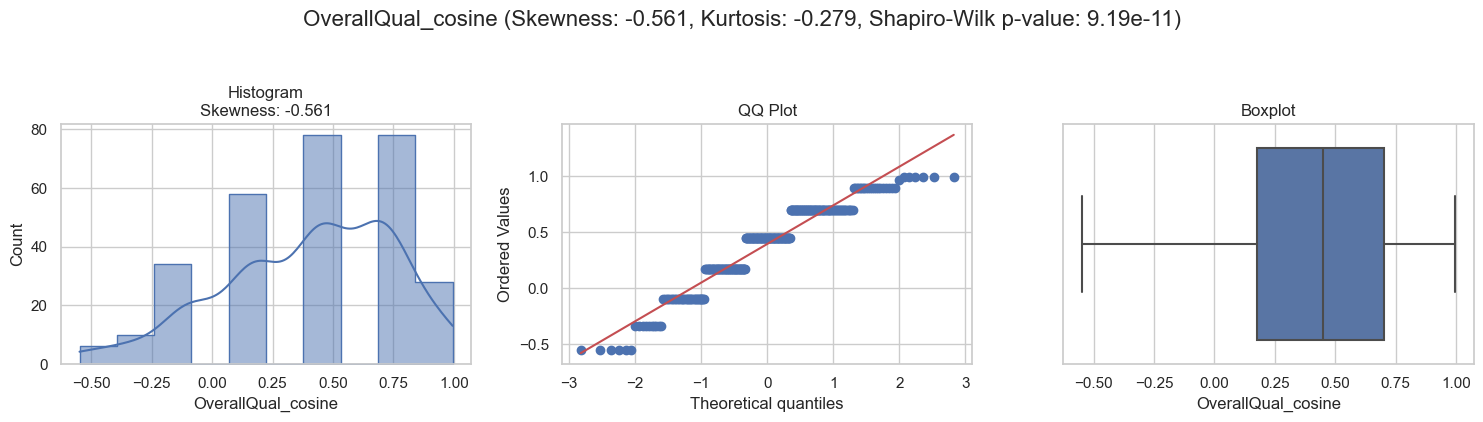



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson', 'GrLivArea_min_max', 'GrLivArea_max_abs', 'GrLivArea_robust', 'GrLivArea_quantile_normal', 'GrLivArea_quantile_uniform', 'GrLivArea_sine', 'GrLivArea_cosine'] 



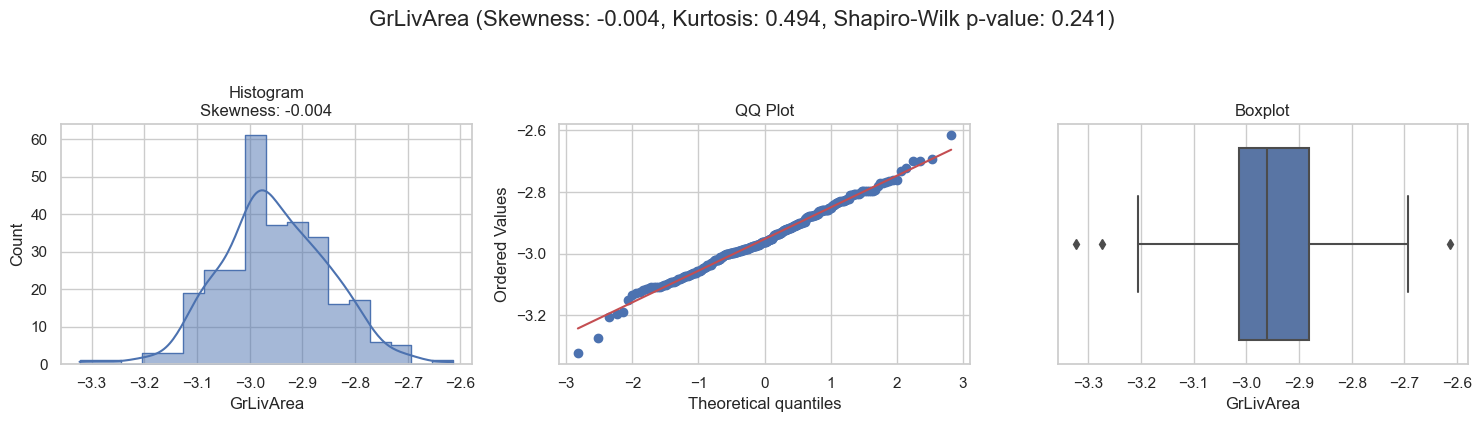

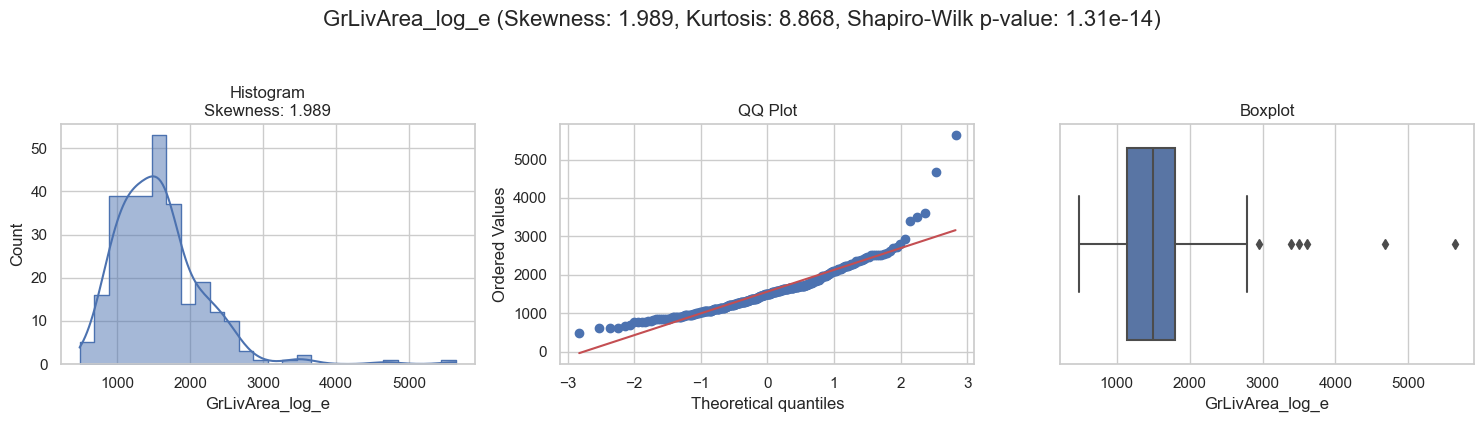

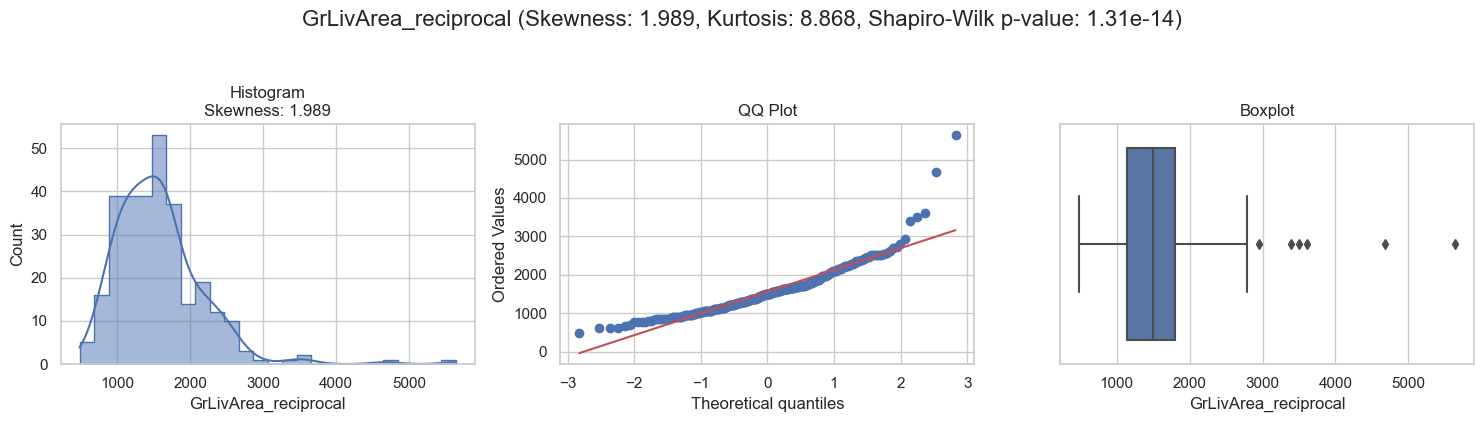

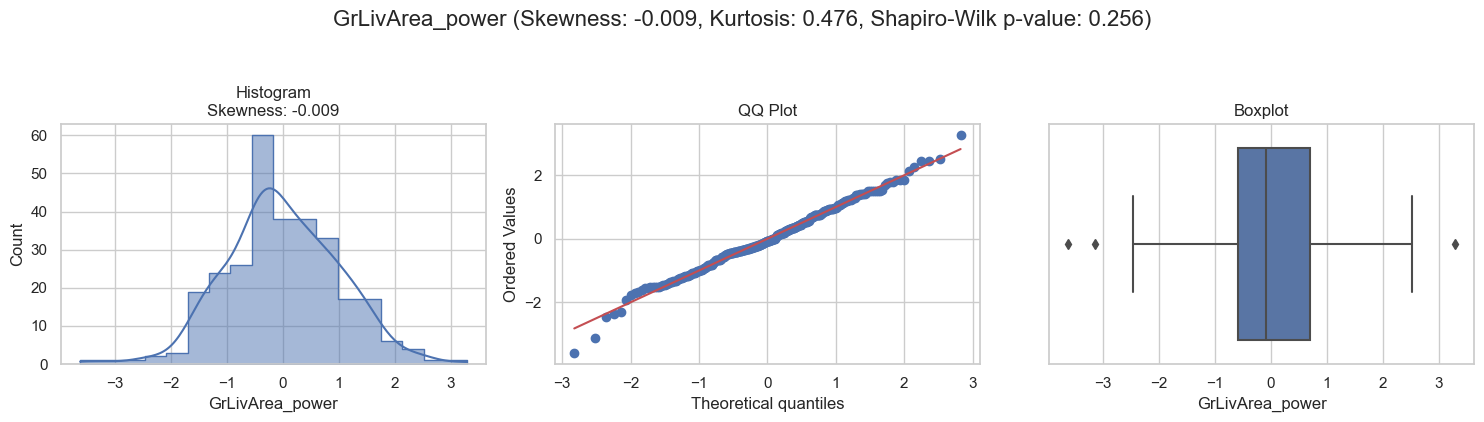

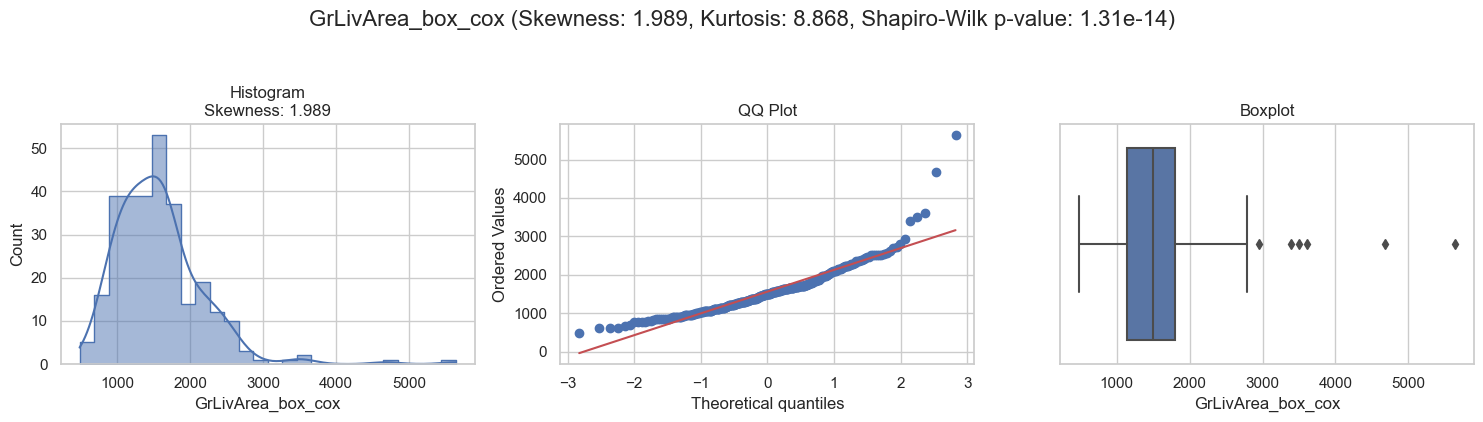

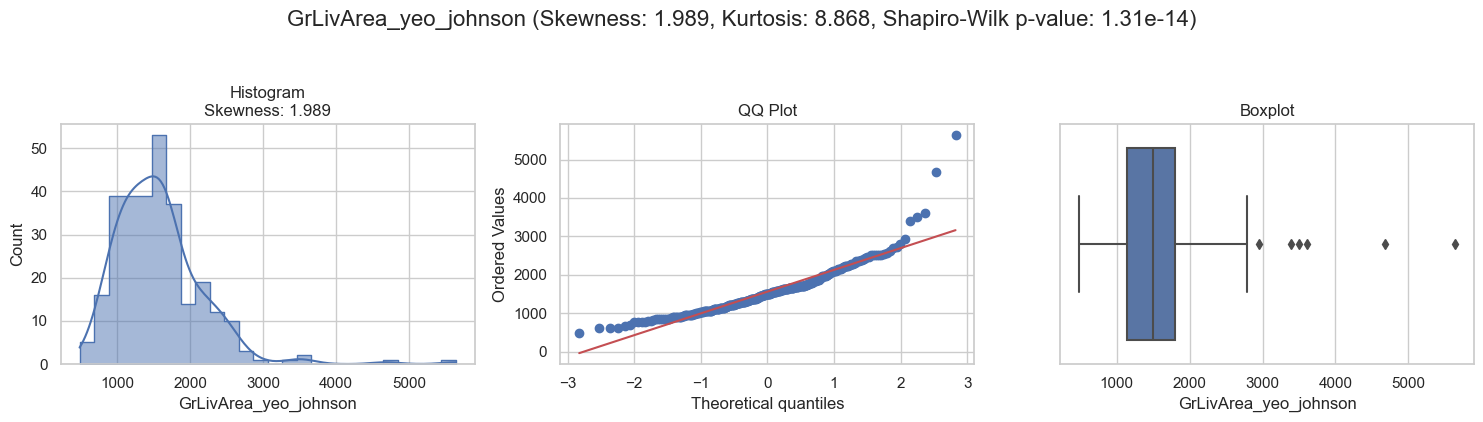

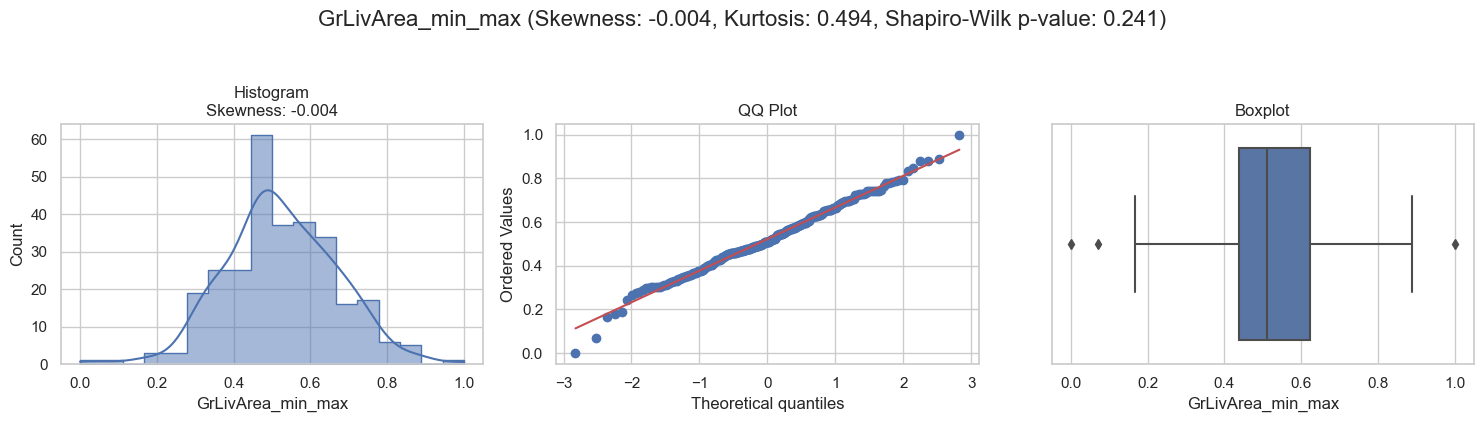

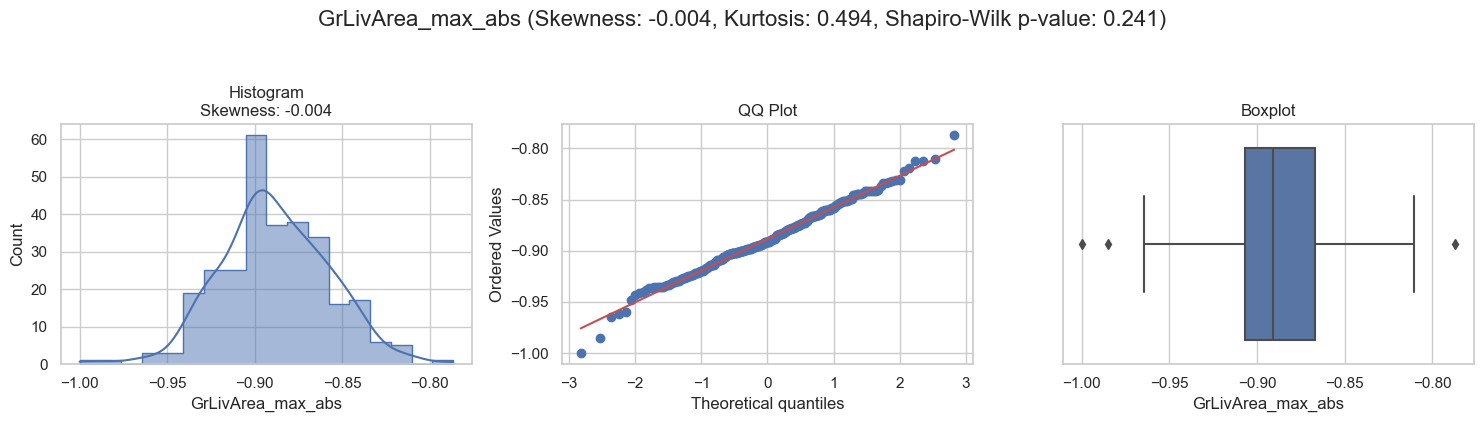

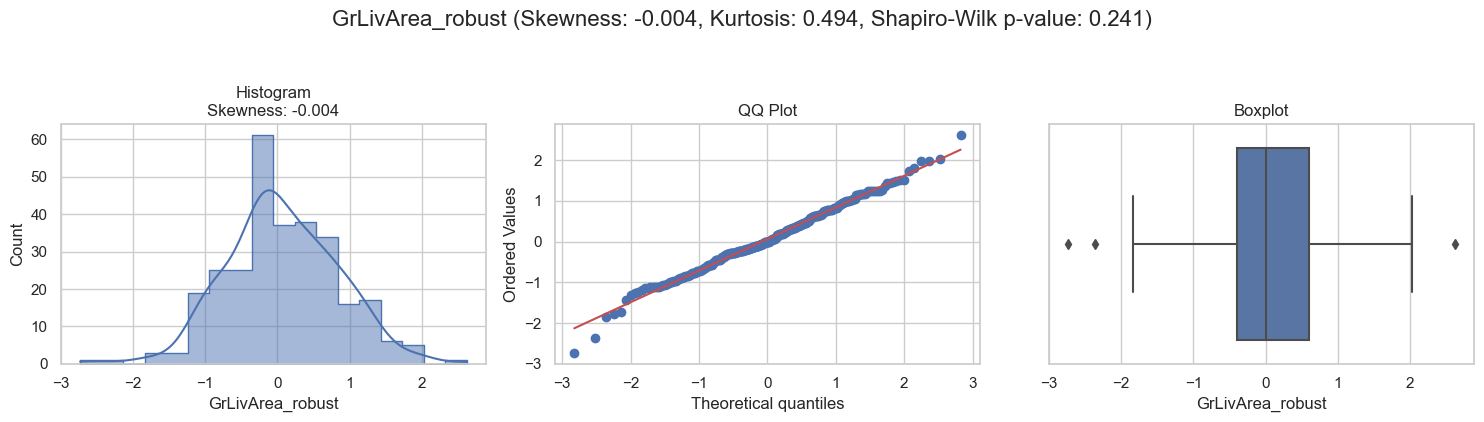

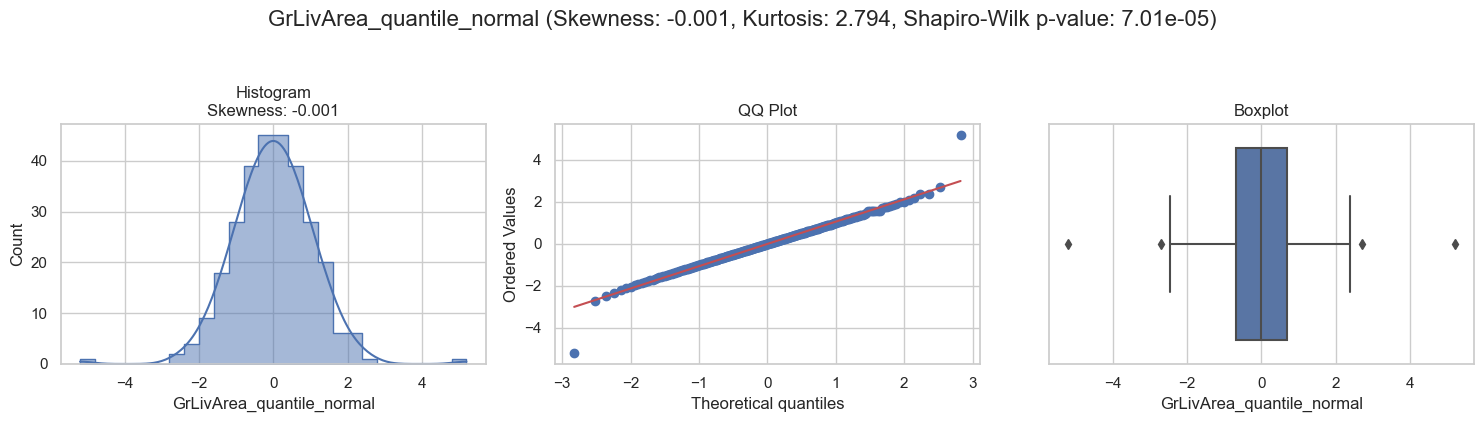

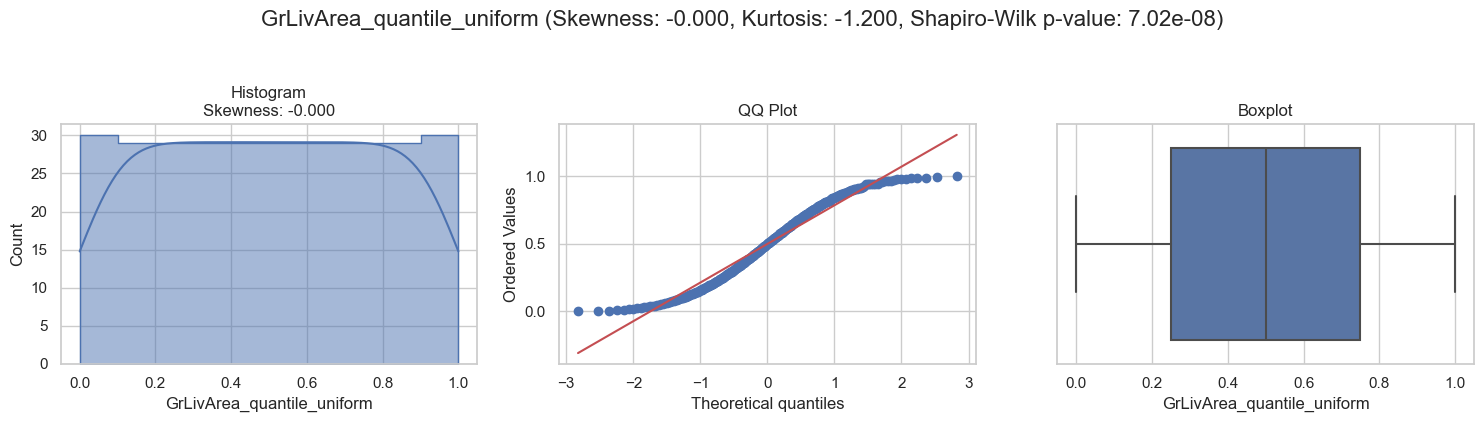

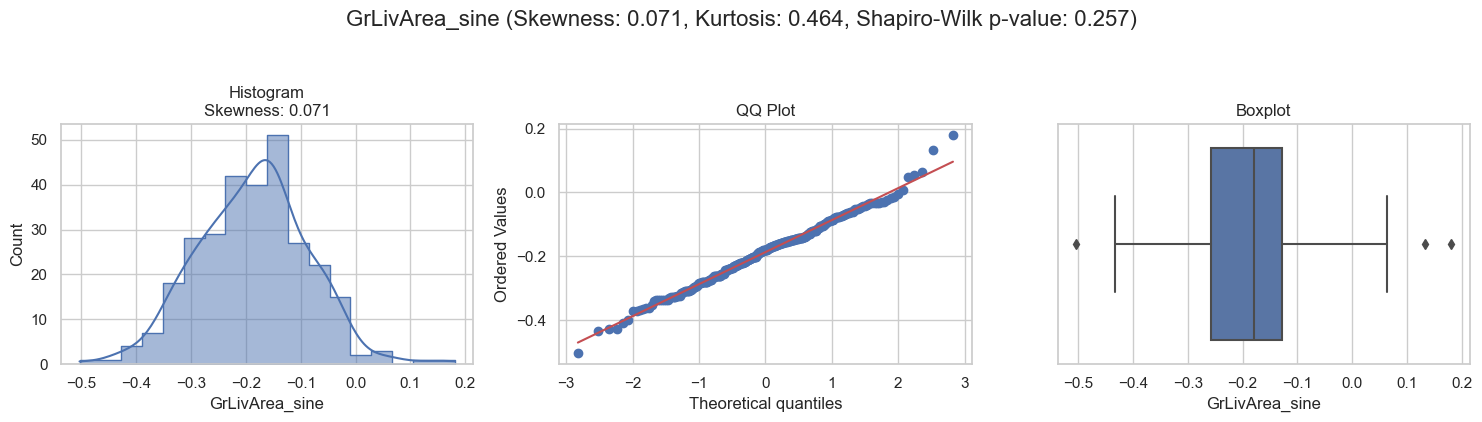

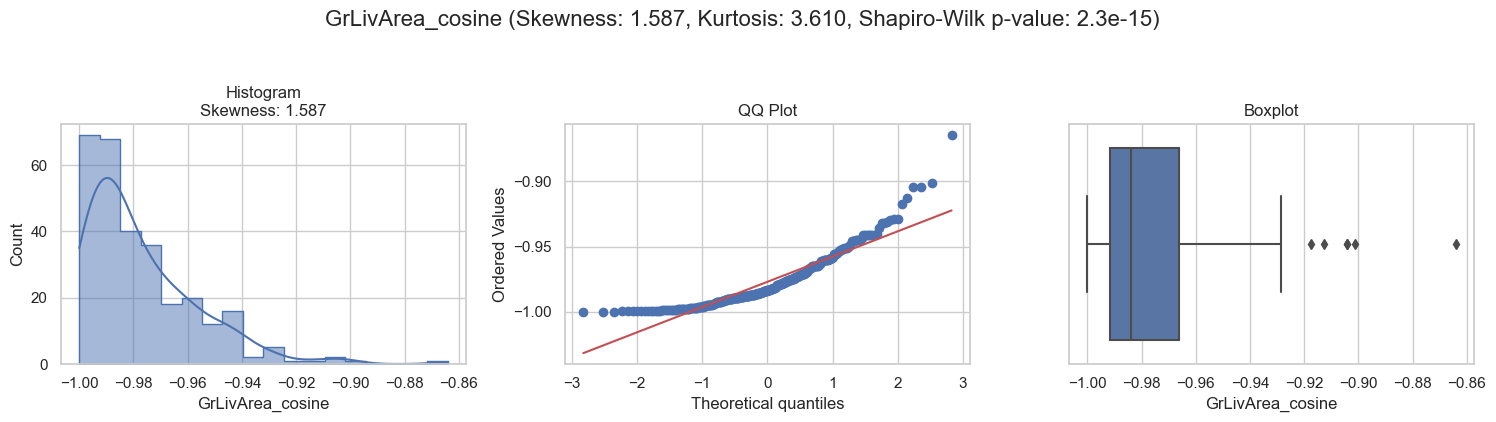



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson', 'SalePrice_min_max', 'SalePrice_max_abs', 'SalePrice_robust', 'SalePrice_quantile_normal', 'SalePrice_quantile_uniform', 'SalePrice_sine', 'SalePrice_cosine'] 



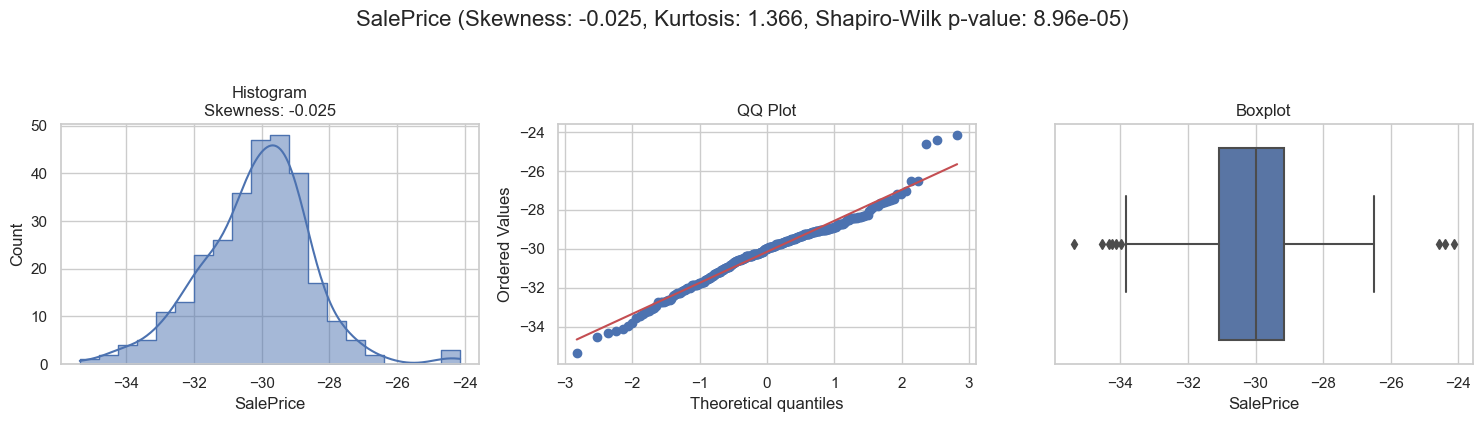

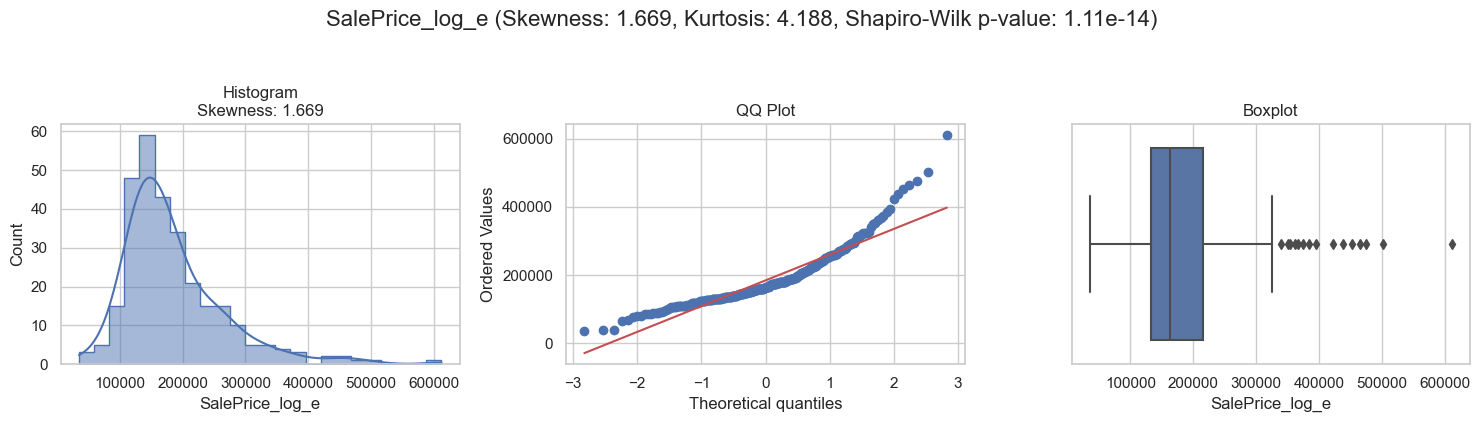

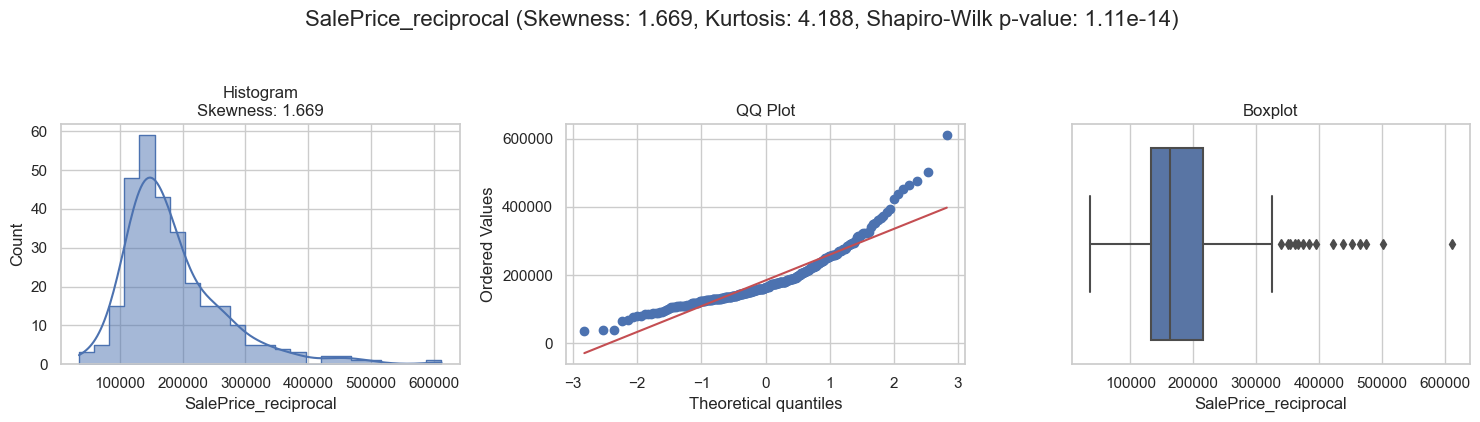

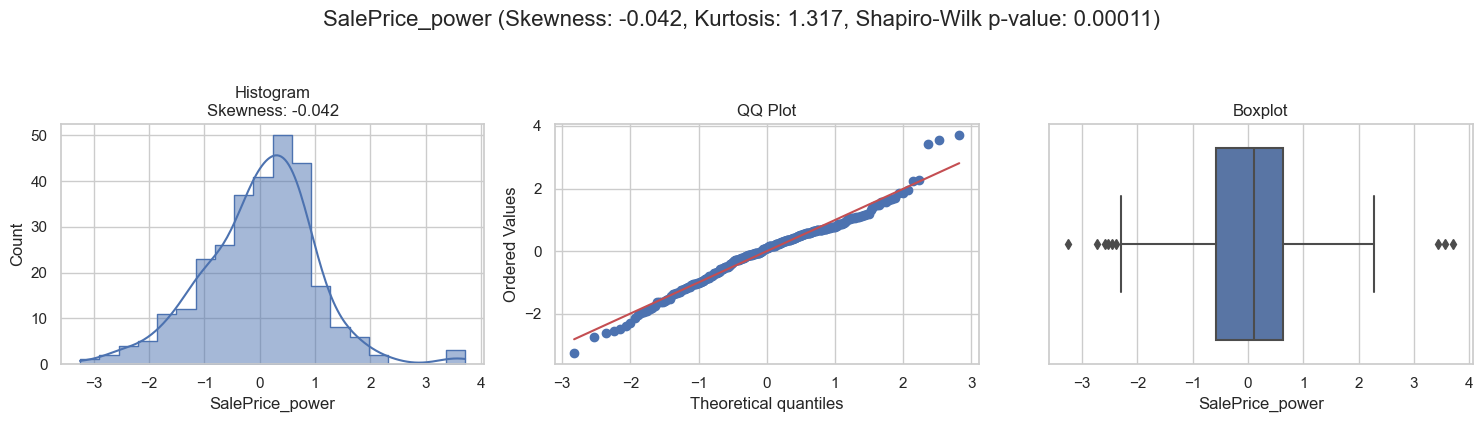

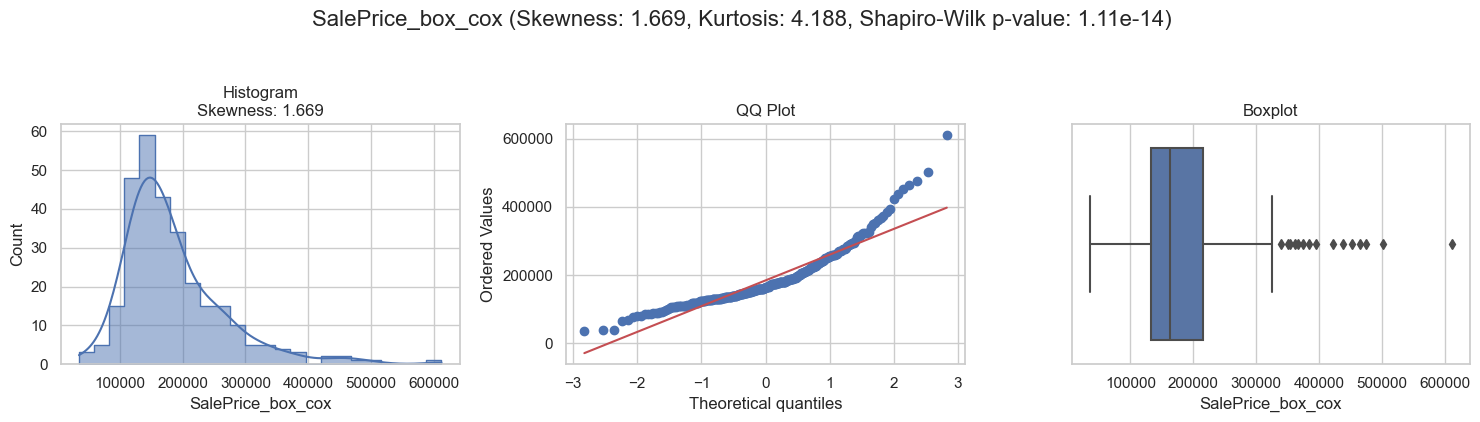

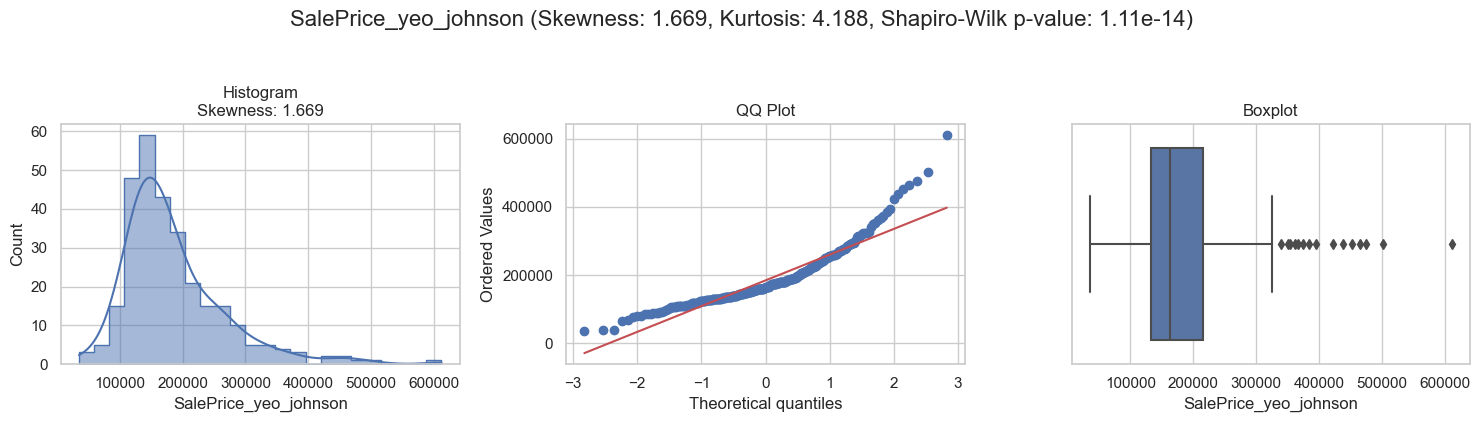

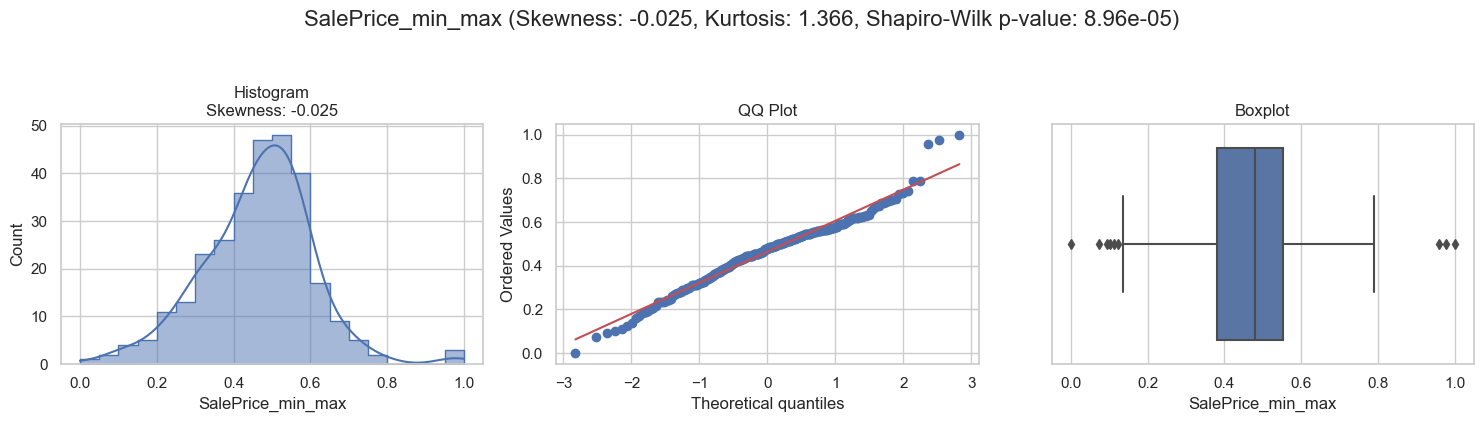

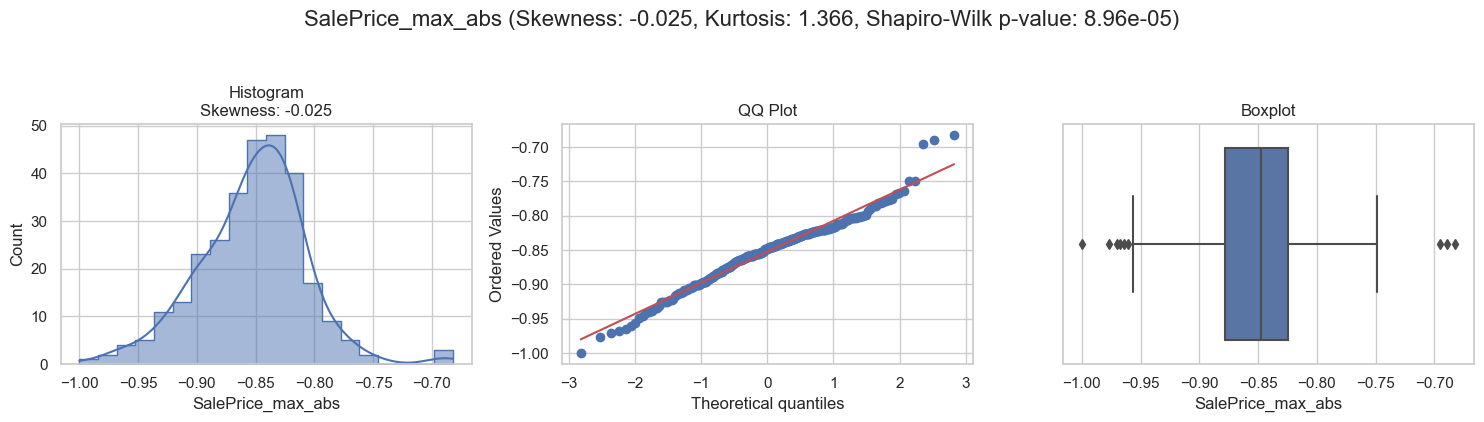

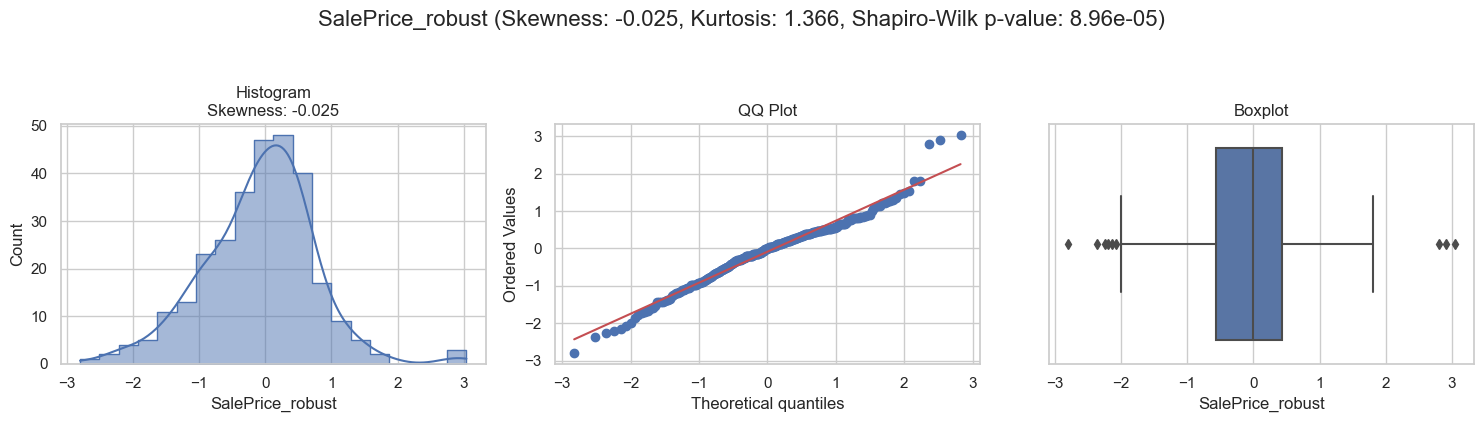

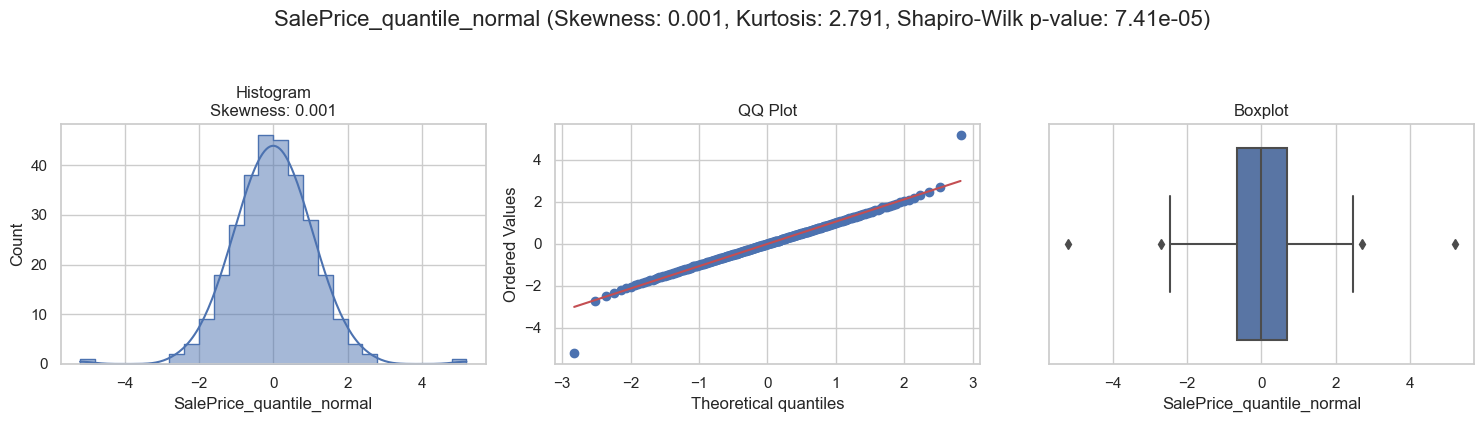

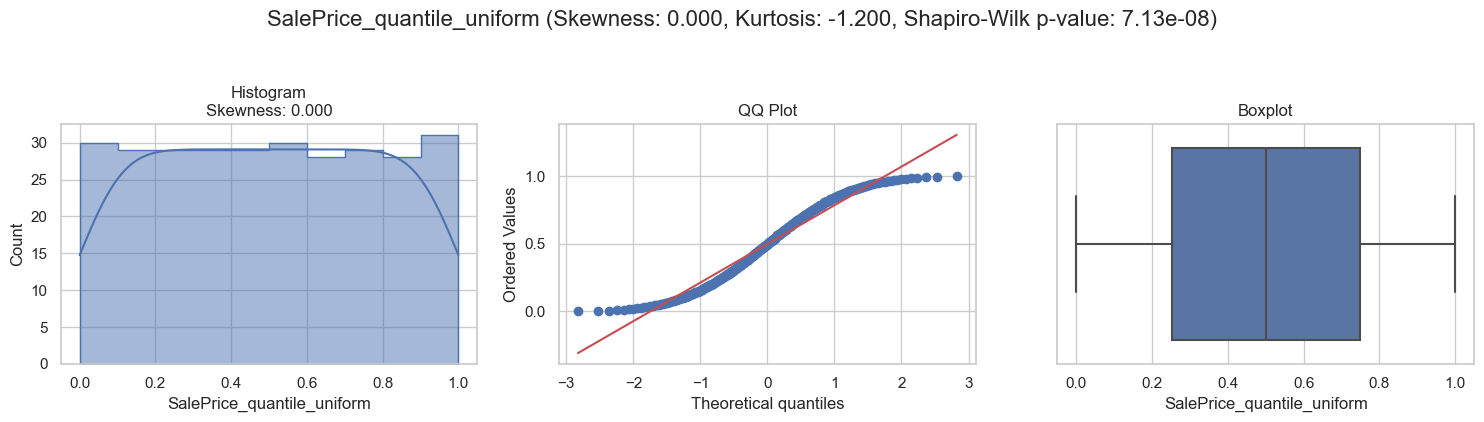

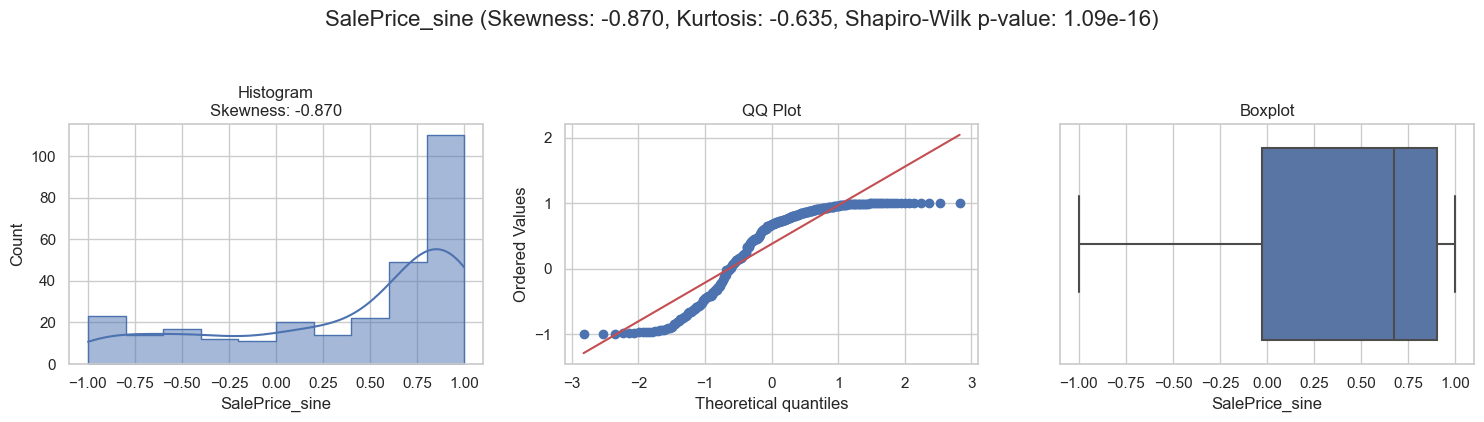

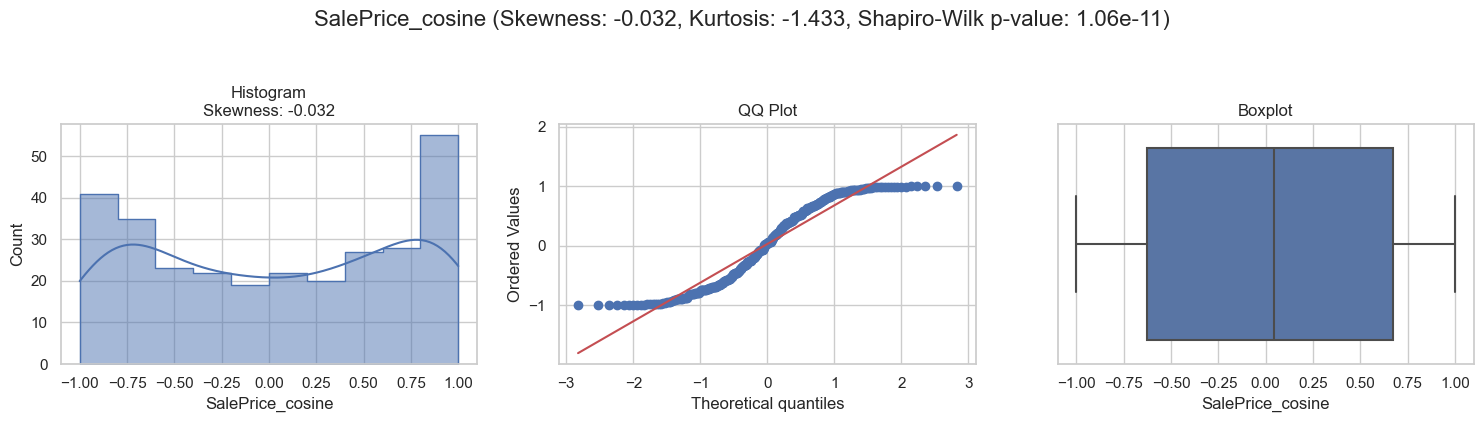

In [8]:
df_transformed = FeatureEngineeringAnalysis(df=df, analysis_type='numerical')

### Based on plots above we can select best transformations for each feature:
1. TotalBsmtSF:
* Quantile Uniform
* Sine
* Cosine
2. 1stFlrSF:
* Original Values
* Log-e
* Box_Cox
* Min_Max
* Quantile Normal
3. YearBuilt:
* Quantile Uniform
* Yeo Johnson
* Power
* Min_Max 
4. GarageArea:
* Quantile Uniform
* Sine
* Cosine
* Yeo Johnson
5. GarageYrBlt:
* Quantile Uniform
* Quantile Normal
* Cosine
6. OverallQual:
* Power
* Original Values
* Min_Max
* Max_Abs
7. GrLivArea:
* Quantile Normal
* Original Values
* Max_Abs
8. SalePrice:
* Original Values
* Power
* Min Max
* Quantile Normal

## Printing Transformation results

We will print results as dataframe, so it will be short summary of all applied transformations, then we can analyze it

In [9]:
import pandas as pd
import scipy.stats as stats

def calculate_statistics(df):
    """
    Calculate skewness, kurtosis, and the p-value of the Shapiro-Wilk test for each numeric feature.
    Also, calculate mean, median, standard deviation, minimum, and maximum.

    Parameters:
        df (DataFrame): The DataFrame with numeric features.

    Returns:
        DataFrame: A new DataFrame with each row representing a feature and its statistics.
    """
    stats_list = []  # Use a list to collect all row data

    for column in df.select_dtypes(include=[np.number]).columns:
        mean_val = df[column].mean()
        median_val = df[column].median()
        std_dev = df[column].std()
        min_val = df[column].min()
        max_val = df[column].max()
        skewness = stats.skew(df[column], nan_policy='omit')
        kurtosis_val = stats.kurtosis(df[column], nan_policy='omit')

        # Append row to list
        stats_list.append({
            'Feature': column,
            'Mean': mean_val,
            'Median': median_val,
            'Std Dev': std_dev,
            'Min': min_val,
            'Max': max_val,
            'Skewness': skewness,
            'Kurtosis': kurtosis_val,
        })

    # Convert list of dictionaries to DataFrame
    stats_df = pd.DataFrame(stats_list)
    return stats_df

statistics_df = calculate_statistics(df_transformed)

In [10]:
statistics_df.head()

Feature          Mean       Median     Std Dev       Min  \
0              TotalBsmtSF  1.285124e+02   127.740100   37.588868  0.000000   
1        TotalBsmtSF_power -1.581688e-16    -0.020581    1.001717 -3.424765   
2  TotalBsmtSF_yeo_johnson  1.090726e+03  1040.000000  503.769891  0.000000   
3      TotalBsmtSF_min_max  3.246845e-01     0.322733    0.094968  0.000000   
4      TotalBsmtSF_max_abs  3.246845e-01     0.322733    0.094968  0.000000   

           Max  Skewness   Kurtosis  
0   395.807080  0.693729  10.516013  
1     7.123214  0.693729  10.516013  
2  6110.000000  3.711525  33.469120  
3     1.000000  0.693729  10.516013  
4     1.000000  0.693729  10.516013

### Now we will make code to give us at least 3 best transformation for each feature

In [11]:
def select_best_transformations(df, n_transformations=3):
    """
    Select the best transformations for each feature based on the lowest absolute skewness and 
    the highest Shapiro-Wilk p-value.

    Parameters:
        df (DataFrame): A DataFrame with columns 'Feature', 'Skewness', 'Kurtosis', 
                        'Shapiro-Wilk p-value', and possibly others.
        n_transformations (int): The number of top transformations to select for each feature.

    Returns:
        DataFrame: A DataFrame with the top transformations for each feature.
    """
    # Split 'Feature' into 'Base Feature' and 'Transformation Method'
    df[['Base Feature', 'Transformation Method']] = df['Feature'].str.split('_', n=1, expand=True)
    df['Transformation Method'].fillna('Original', inplace=True)  # Handle cases with no underscore

    # Create a new column for absolute skewness to sort by it
    df['Abs Skewness'] = df['Skewness'].abs()

    # Sort the DataFrame by absolute skewness
    sorted_df = df.sort_values(by=['Abs Skewness'], ascending=[True])

    # Group by the base feature and select the top transformations
    top_transformations = sorted_df.groupby('Base Feature').head(n_transformations).reset_index(drop=True)

    # Return the DataFrame sorted by 'Base Feature'
    return top_transformations.sort_values(by='Base Feature')[['Base Feature', 'Skewness', 'Kurtosis', 'Transformation Method']]

best_transforms = select_best_transformations(statistics_df)


In [12]:
best_transforms

Base Feature  Skewness  Kurtosis Transformation Method
0      1stFlrSF -0.000063 -1.200107      quantile_uniform
3      1stFlrSF -0.000496  0.375548               max_abs
4      1stFlrSF -0.000496  0.375548              Original
20   GarageArea -0.167469  1.195394              Original
16   GarageArea  0.024474 -1.201107                  sine
14   GarageArea -0.013837 -1.183050      quantile_uniform
21  GarageYrBlt  0.194451 -1.641377                cosine
6   GarageYrBlt  0.000746 -1.202833      quantile_uniform
15  GarageYrBlt  0.019536  2.802929       quantile_normal
1     GrLivArea -0.000075 -1.200189      quantile_uniform
7     GrLivArea -0.001354  2.794393       quantile_normal
8     GrLivArea -0.004165  0.493992               max_abs
13  OverallQual -0.010551  0.061063                robust
11  OverallQual -0.010551  0.061063               min_max
12  OverallQual -0.010551  0.061063              Original
17    SalePrice -0.024993  1.365546              Original
5     SalePrice  0.000569  2.791095       quantile_normal
2     SalePrice  0.000171 -1.199841      quantile_uniform
9   TotalBsmtSF -0.004899 -1.193261      quantile_uniform
18  TotalBsmtSF -0.028570 -1.511061                cosine
19  TotalBsmtSF -0.092216 -1.426357                  sine
22    YearBuilt -0.711481 -0.146343                 log_e
10    YearBuilt -0.006260 -1.174502      quantile_uniform
23    YearBuilt -0.711481 -0.146343            reciprocal

### Based on Selection above, if they do not exsis in previous list, we will add them:
1. TotalBsmtSF:
* Quantile Uniform
* Sine
* Cosine
2. 1stFlrSF:
* Original Values
* Log-e
* Box Cox
* Min Max
* Quantile Normal
* Quantile Uniform
* Max Abs
3. YearBuilt:
* Quantile Uniform
* Yeo Johnson
* Power
* Min Max
* Reciprocal 
4. GarageArea:
* Quantile Uniform
* Sine
* Cosine
* Yeo Johnson
* Original Values
5. GarageYrBlt:
* Quantile Uniform
* Quantile Normal
* Cosine
6. OverallQual:
* Power
* Original Values
* Min Max
* Max Abs
* Robust
7. GrLivArea:
* Quantile Normal
* Original Values
* Max Abs
* Quantile Uniform
8. SalePrice:
* Original Values
* Power
* Min Max
* Quantile Normal
* Quantile Uniform

## Conclusions:

We will add these transformations to ML Pipeline:

- **Original Values** : [`1stFlrSF`, `GarageArea`, `OverallQual`, `GrLivArea`, `SalePrice`]
- **Quantile Uniform** : [`TotalBsmtSF`, `1stFlrSF`, `YearBuilt`, `GarageArea`, `GarageYrBlt`, `GrLivArea`, `SalePrice`]
- **Sine** : [`TotalBsmtSF`, `GarageArea`]
- **Cosine** : [`TotalBsmtSF`, `GarageArea`, `GarageYrBlt`]
- **Log-e** : [`1stFlrSF`]
- **Box Cox** : [`1stFlrSF`]
- **Min Max** : [`1stFlrSF`, `YearBuilt`, `OverallQual`, `SalePrice`]
- **Quantile Normal** : [`1stFlrSF`, `GarageYrBlt`, `GrLivArea`, `SalePrice`]
- **Max Abs** : [`1stFlrSF`, `OverallQual`, `GrLivArea`]
- **Power** : [`YearBuilt`, `OverallQual`, `SalePrice`]
- **Yeo Johnson** : [`YearBuilt`, `GarageArea`]
- **Reciprocal** : [`YearBuilt`]
- **Robust** : [`OverallQual`]

## Next step is ML model creation and it's evaluation